In [1]:
#standard libraries
import pandas as pd
import numpy as np
import tensorflow as tf

#visualization
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import seaborn as sns

#other scripts
from functions import WindowGenerator
from functions import dataToTimeSeries

#pre-processing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#ML models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

#DL models
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#ARIMA
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.utils import timeseries_dataset_from_array


# Import and merge data

## Pop tags (sensor value)

In [3]:
# tags_df = pd.read_csv('./dataframes/test_tag_years.csv')
tags_df = pd.read_csv('./dataframes/all_good_tags_from_2022.csv')
tags_df.head()

,DateTime,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016
0,2022-01-01 20:16:23.000,0.0,0.0,-74.074081,-0.108505,-2.405243,1705.222168,-474.074066,0.005968,0.0,89.699066
1,2022-01-01 20:16:27.461,NaN,NaN,-74.092163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 20:16:29.999,NaN,NaN,NaN,NaN,NaN,1598.583252,NaN,0.005968,NaN,NaN
3,2022-01-01 20:16:30.000,NaN,NaN,NaN,-0.325516,-2.332901,NaN,NaN,NaN,NaN,89.699066
4,2022-01-01 20:16:36.462,NaN,NaN,NaN,-0.072342,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
tags_df.shape

(12950701, 11)

In [5]:
tags_df.isnull().sum()

DateTime                   0
GLA01_BL_258_104    12175727
GLA01_CH_258_020     7352828
GLA3_CO_258_024      8199616
GLA3_CO_258_028      9924085
GLA3_CO_258_032      9929050
GLA3_EM_158_140     12050486
GLA3_EM_158_144     12950680
GLA3_RE_258_740      9933783
GLA3_RP_258_004     12947590
GLA3_SC_258_016      9910690
dtype: int64

In [6]:
transform=dataToTimeSeries(tags_df)
tags_df_transformed = transform.transform_round_and_fill(method='ffill')

In [7]:
tags_df_transformed

,DateTime,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016
0,2022-01-01 20:16:23,0.0,0.0,-74.074081,-0.108505,-2.405243,1705.222168,-474.074066,0.005968,0.0,89.699066
1,2022-01-01 20:16:27,0.0,0.0,-74.092163,-0.108505,-2.405243,1705.222168,-474.074066,0.005968,0.0,89.699066
2,2022-01-01 20:16:29,0.0,0.0,-74.092163,-0.108505,-2.405243,1598.583252,-474.074066,0.005968,0.0,89.699066
3,2022-01-01 20:16:30,0.0,0.0,-74.092163,-0.325516,-2.332901,1598.583252,-474.074066,0.005968,0.0,89.699066
4,2022-01-01 20:16:36,0.0,0.0,-74.092163,-0.072342,-2.332901,1598.583252,-474.074066,0.005968,0.0,89.699066
...,...,...,...,...,...,...,...,...,...,...,...
12950695,2022-12-12 08:32:51,0.0,0.0,-7.107208,1.103149,-6.184891,52927.433594,-474.074066,8.067492,0.0,-173.611084
12950696,2022-12-12 08:32:54,0.0,0.0,-7.703995,1.103149,-6.184891,52927.433594,-474.074066,8.067492,0.0,-173.611084
12950697,2022-12-12 08:32:57,0.0,0.0,-8.445465,1.103149,-6.184891,52927.433594,-474.074066,8.067492,0.0,-173.611084
12950698,2022-12-12 08:32:59,0.0,0.0,-8.445465,1.103149,-6.184891,53958.277344,-474.074066,8.067492,0.0,-173.611084


In [8]:
tags_df_resampled = tags_df_transformed.resample('1T', on='DateTime').mean()
tags_df_resampled.head()

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016
DateTime,,,,,,,,,,
2022-01-01 20:16:00,0.0,0.0,-74.095177,-0.140157,-2.388664,1614.875315,-474.074066,0.006104,0.0,90.784138
2022-01-01 20:17:00,0.0,0.0,-74.126319,-0.079374,-2.428345,1526.503276,-474.074066,0.006028,0.0,93.396345
2022-01-01 20:18:00,0.0,0.0,-74.121946,-0.076596,-2.438219,1484.626027,-474.074066,0.006000,0.0,90.465003
2022-01-01 20:19:00,0.0,0.0,-74.066162,-0.218143,-2.529572,1449.733192,-474.074066,0.005697,0.0,91.688365
2022-01-01 20:20:00,0.0,0.0,-74.076487,-0.135030,-2.472752,1420.851782,-474.074066,0.005389,0.0,92.978392


## Downtimes

In [9]:
downtime_df = pd.read_csv('all_downtimes_processed.csv')
downtime_df.head()

,DateTime,trigger,downtime
0,2020-01-06 10:00:00,1.0,1
1,2020-01-06 10:01:00,0.0,1
2,2020-01-06 10:02:00,0.0,1
3,2020-01-06 10:03:00,0.0,1
4,2020-01-06 10:04:00,0.0,1


In [10]:
downtime_df['DateTime'] = pd.to_datetime(downtime_df['DateTime'])
downtime_df.set_index('DateTime', inplace=True)

## Merge

In [11]:
df = tags_df_resampled.merge(downtime_df, left_index= True, right_index= True, how="left")
df.fillna(0, inplace=True)
df.head()

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,,,
2022-01-01 20:16:00,0.0,0.0,-74.095177,-0.140157,-2.388664,1614.875315,-474.074066,0.006104,0.0,90.784138,0.0,1
2022-01-01 20:17:00,0.0,0.0,-74.126319,-0.079374,-2.428345,1526.503276,-474.074066,0.006028,0.0,93.396345,0.0,1
2022-01-01 20:18:00,0.0,0.0,-74.121946,-0.076596,-2.438219,1484.626027,-474.074066,0.006000,0.0,90.465003,0.0,1
2022-01-01 20:19:00,0.0,0.0,-74.066162,-0.218143,-2.529572,1449.733192,-474.074066,0.005697,0.0,91.688365,0.0,1
2022-01-01 20:20:00,0.0,0.0,-74.076487,-0.135030,-2.472752,1420.851782,-474.074066,0.005389,0.0,92.978392,0.0,1


In [12]:
df.columns

Index(['GLA01_BL_258_104', 'GLA01_CH_258_020', 'GLA3_CO_258_024',
       'GLA3_CO_258_028', 'GLA3_CO_258_032', 'GLA3_EM_158_140',
       'GLA3_EM_158_144', 'GLA3_RE_258_740', 'GLA3_RP_258_004',
       'GLA3_SC_258_016', 'trigger', 'downtime'],
      dtype='object')

In [13]:
df.shape

(496098, 12)

## Plots

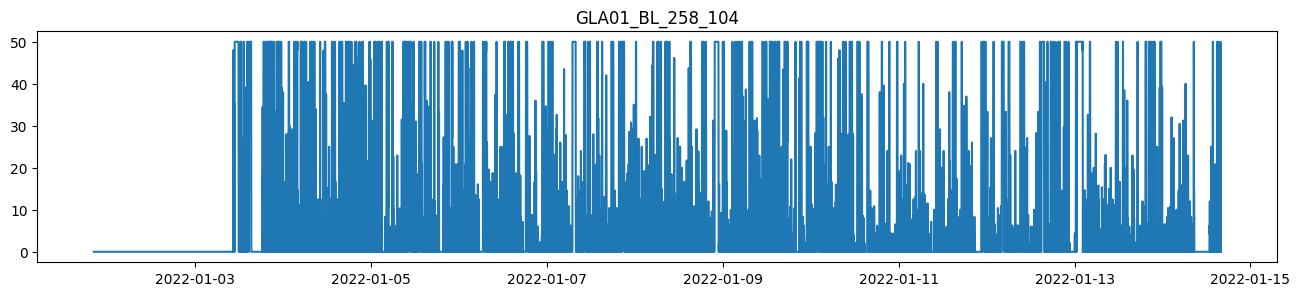

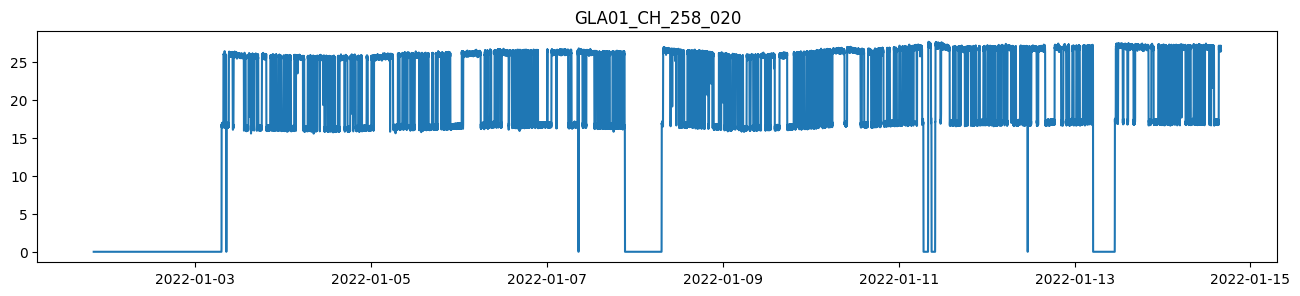

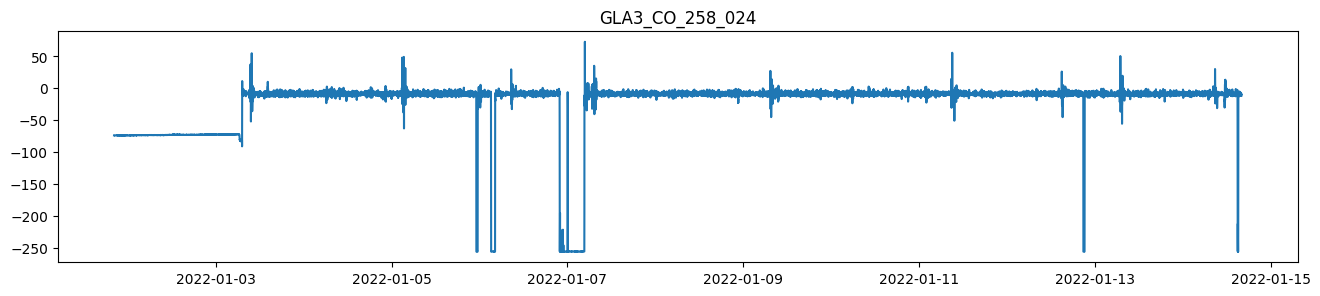

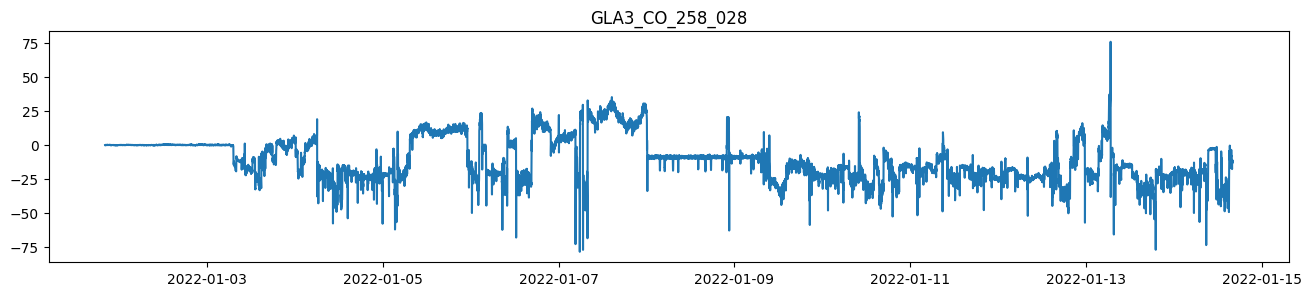

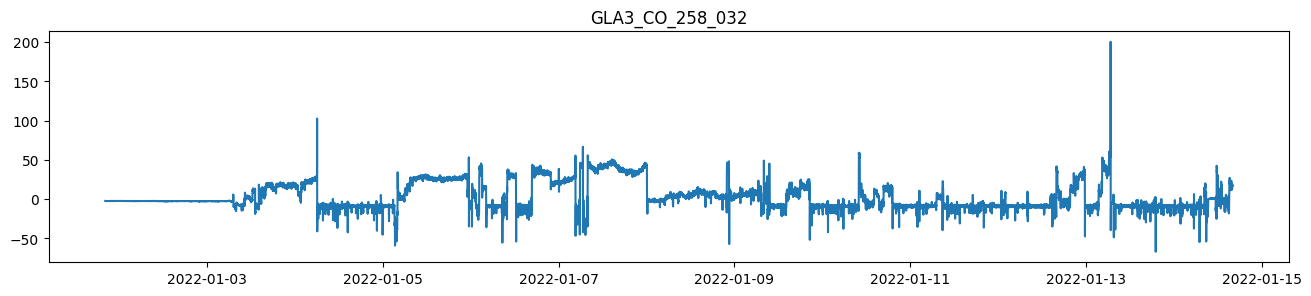

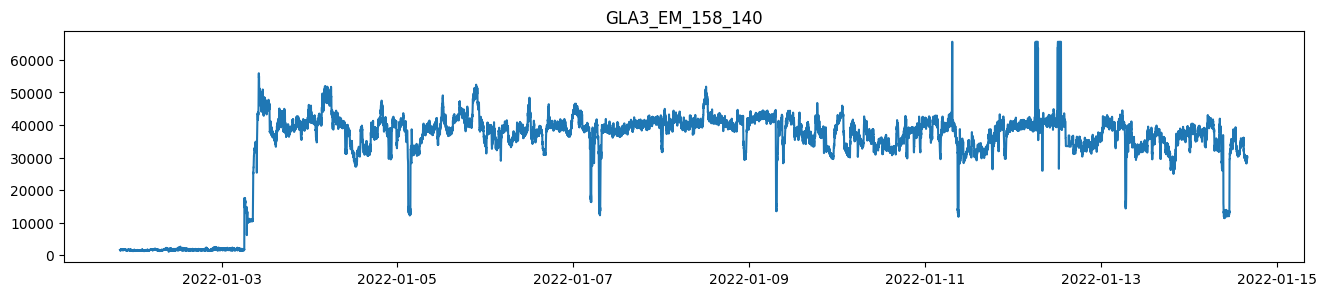

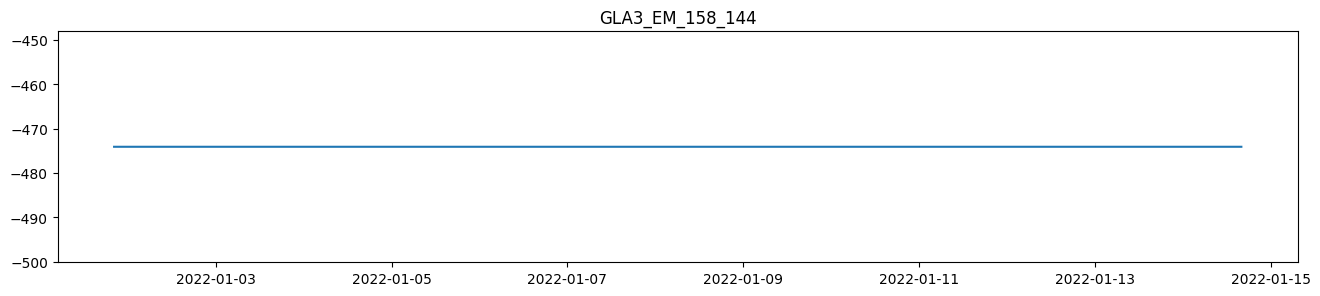

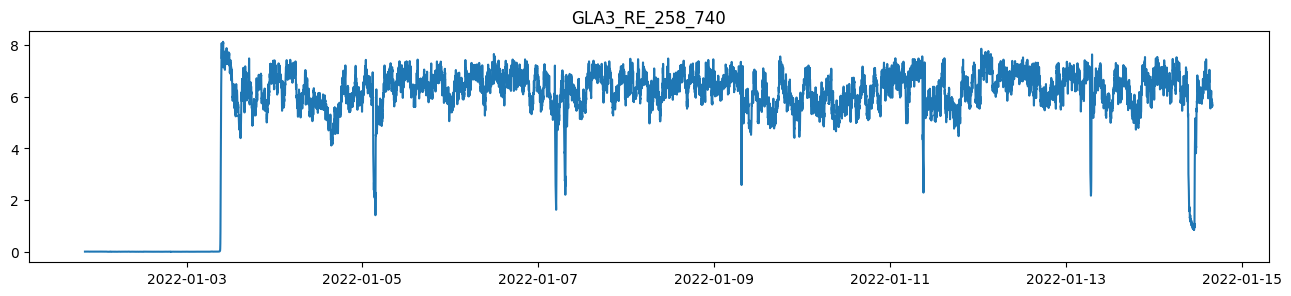

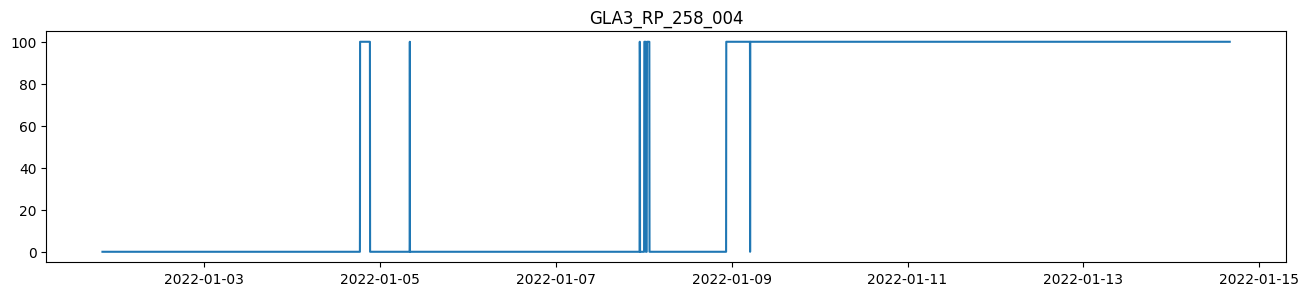

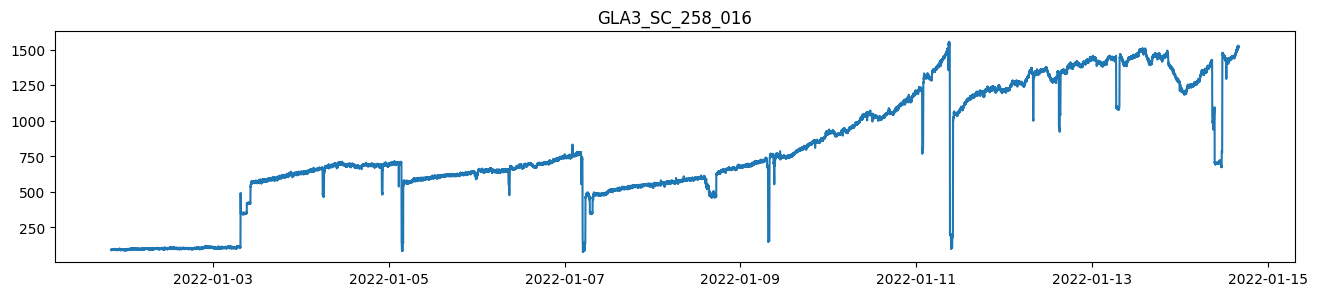

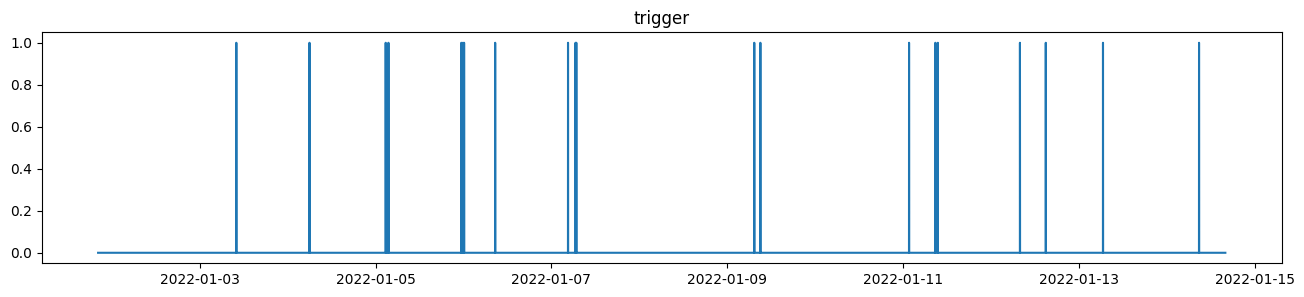

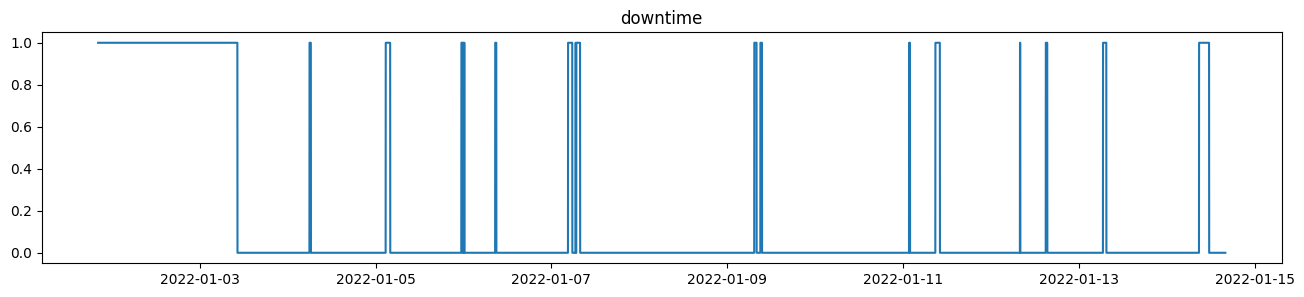

In [ ]:
for column in df.columns:
    plt.figure(figsize=(16, 3))
    plt.plot(df[column])
    plt.title(column)
    plt.show()

In [ ]:
df.drop(columns=['GLA3_EM_158_144'],
                 inplace=True)

# df.drop(columns=['GLA3_SP_258_2396', 'GLA3_SP_258_1996'],
#                   inplace=True)




<Axes: >

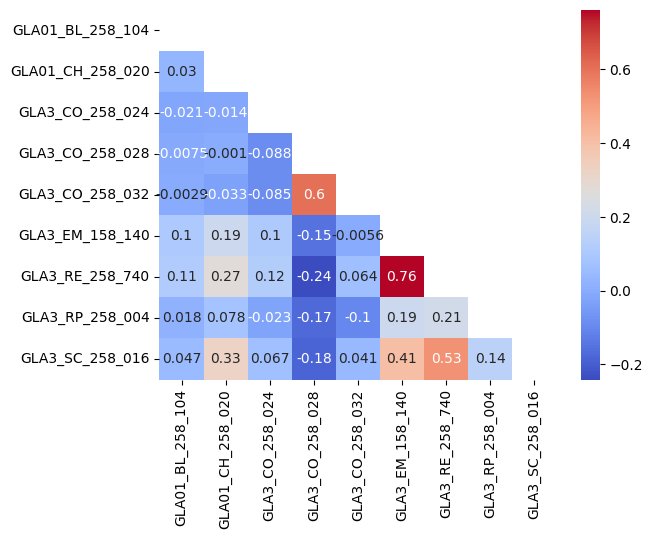

In [ ]:
corr_matrix = df.drop(columns=['trigger', 'downtime']).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm')

In [ ]:
df

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,,
2022-01-01 20:16:00,0.0,0.0,-74.095177,-0.140157,-2.388664,1614.875315,0.006104,0.0,90.784138,0.0,1
2022-01-01 20:17:00,0.0,0.0,-74.126319,-0.079374,-2.428345,1526.503276,0.006028,0.0,93.396345,0.0,1
2022-01-01 20:18:00,0.0,0.0,-74.121946,-0.076596,-2.438219,1484.626027,0.006000,0.0,90.465003,0.0,1
2022-01-01 20:19:00,0.0,0.0,-74.066162,-0.218143,-2.529572,1449.733192,0.005697,0.0,91.688365,0.0,1
2022-01-01 20:20:00,0.0,0.0,-74.076487,-0.135030,-2.472752,1420.851782,0.005389,0.0,92.978392,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:29:00,0.0,0.0,-8.783500,3.289984,-6.479813,50759.792518,7.699632,0.0,-113.348004,0.0,0
2022-12-12 08:30:00,0.0,0.0,-5.698065,2.285154,-6.158857,51086.847344,7.731337,0.0,-146.643506,0.0,0
2022-12-12 08:31:00,0.0,0.0,-8.485801,1.325036,-9.147971,51750.987981,7.751778,0.0,-164.095858,0.0,0


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming you have a DataFrame called 'df' with columns representing different sensors

# Select the predictor variables (all columns except 'timestamp')
predictors = df.drop(columns=['trigger', 'downtime'])

# Calculate VIF values for each predictor variable
vif_values = pd.DataFrame()
vif_values["Variable"] = predictors.columns
vif_values["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

print(vif_values)


           Variable        VIF
0  GLA01_BL_258_104   1.364119
1  GLA01_CH_258_020   2.631036
2   GLA3_CO_258_024   1.173022
3   GLA3_CO_258_028   2.828714
4   GLA3_CO_258_032   1.800431
5   GLA3_EM_158_140  12.439566
6   GLA3_RE_258_740  17.491845
7   GLA3_RP_258_004   1.603698
8   GLA3_SC_258_016   4.148540


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming you have a DataFrame called 'df' with predictor variables
predictors = df.drop(columns=['trigger', 'downtime'])  # Exclude the target and any other non-predictor columns

vif_values = pd.DataFrame()
vif_values["Variable"] = predictors.columns
vif_values["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

print(vif_values)

           Variable        VIF
0  GLA01_BL_258_104   1.364119
1  GLA01_CH_258_020   2.631036
2   GLA3_CO_258_024   1.173022
3   GLA3_CO_258_028   2.828714
4   GLA3_CO_258_032   1.800431
5   GLA3_EM_158_140  12.439566
6   GLA3_RE_258_740  17.491845
7   GLA3_RP_258_004   1.603698
8   GLA3_SC_258_016   4.148540


In [ ]:
df.drop(columns=['GLA3_EM_158_140'], inplace=True)

## Visual inspection

In [ ]:
df.columns

Index(['GLA01_BL_258_104', 'GLA01_CH_258_020', 'GLA3_CO_258_024',
       'GLA3_CO_258_028', 'GLA3_CO_258_032', 'GLA3_RE_258_740',
       'GLA3_RP_258_004', 'GLA3_SC_258_016', 'trigger', 'downtime'],
      dtype='object')

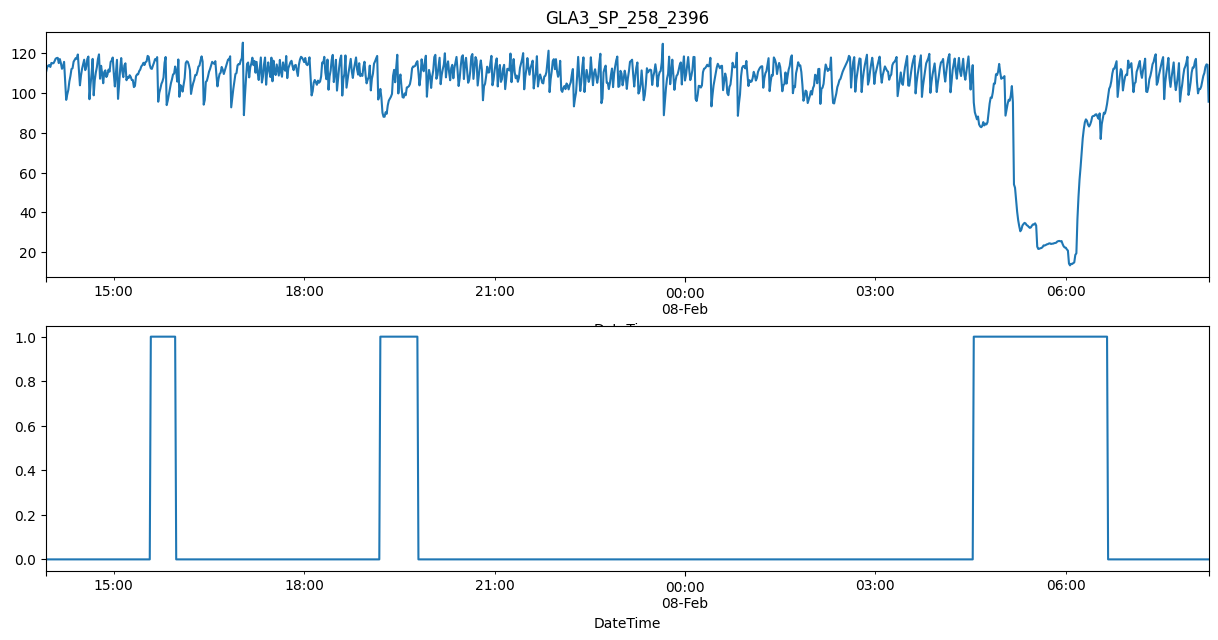

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7))

df['GLA3_FI_258_004'][52900:54000].plot(ax=ax1)
df['downtime'][52900:54000].plot(ax=ax2)

ax1.set_title('GLA3_SP_258_2396')
# ax2.set_title('downtime')

plt.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [29/May/2023 16:31:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/May/2023 16:31:53] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [29/May/2023 16:31:53] "GET /mpld3.js HTTP/1.1" 200 -



stopping Server...


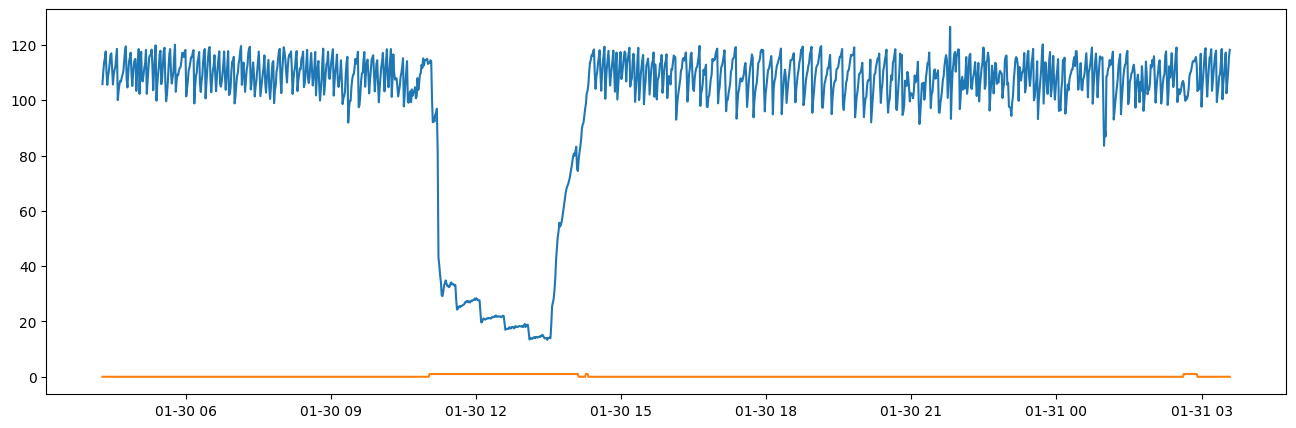

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(df['GLA3_FI_258_004'][40800:42200])
ax.plot(df['downtime'][40800:42200])

plugins.connect(fig, plugins.Zoom())

mpld3.show()



## Visual inspection

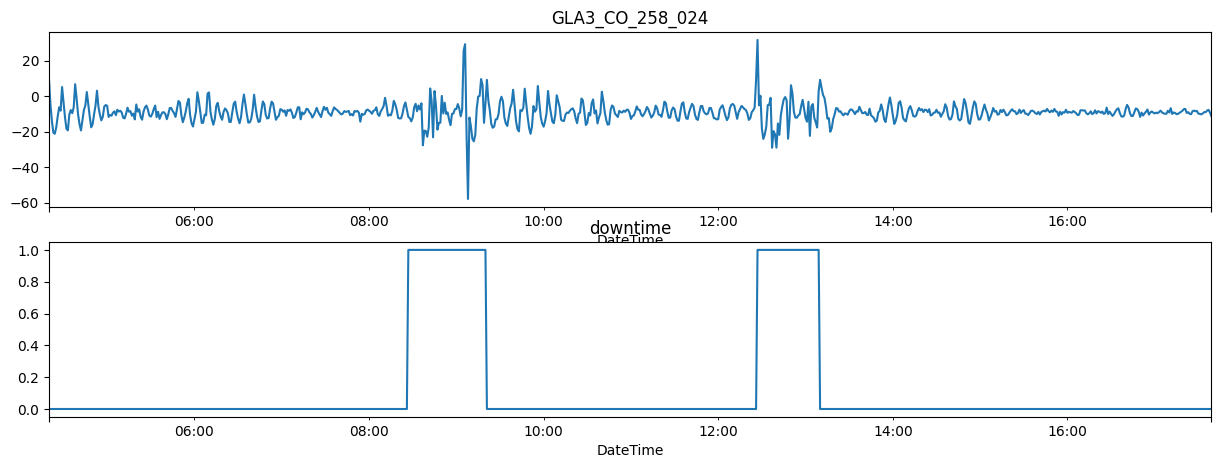

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,5))


df[df.index.year == 2022]['GLA3_CO_258_024'][37700:38500].plot(ax=ax1)
df[df.index.year == 2022]['downtime'][37700:38500].plot(ax=ax2)

ax1.set_title('GLA3_CO_258_024')
ax2.set_title('downtime')

plt.show()

## Pre-processing

In [ ]:
df = pd.read_csv("collab_data.csv")

In [ ]:
df.mean(axis = 0)

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index(df['DateTime'], inplace=True)
df.drop(columns=['DateTime'], inplace=True)

In [ ]:
df

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,
2022-01-01 20:16:00,0.0,0.0,-74.095177,-0.140157,-2.388664,0.006104,0.0,90.784138,0.0,1
2022-01-01 20:17:00,0.0,0.0,-74.126319,-0.079374,-2.428345,0.006028,0.0,93.396345,0.0,1
2022-01-01 20:18:00,0.0,0.0,-74.121946,-0.076596,-2.438219,0.006000,0.0,90.465003,0.0,1
2022-01-01 20:19:00,0.0,0.0,-74.066162,-0.218143,-2.529572,0.005697,0.0,91.688365,0.0,1
2022-01-01 20:20:00,0.0,0.0,-74.076487,-0.135030,-2.472752,0.005389,0.0,92.978392,0.0,1
...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:29:00,0.0,0.0,-8.783500,3.289984,-6.479813,7.699632,0.0,-113.348004,0.0,0
2022-12-12 08:30:00,0.0,0.0,-5.698065,2.285154,-6.158857,7.731337,0.0,-146.643506,0.0,0
2022-12-12 08:31:00,0.0,0.0,-8.485801,1.325036,-9.147971,7.751778,0.0,-164.095858,0.0,0


In [ ]:
numerical_features = df.iloc[:, :-2].columns.tolist()
categorical_features = df.iloc[:,-2:].columns.tolist()

In [ ]:
categorical_features

['trigger', 'downtime']

In [ ]:
data = df.copy()

In [ ]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_features:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496098 entries, 2022-01-01 20:16:00 to 2022-12-12 08:33:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   GLA01_BL_258_104  496098 non-null  float64
 1   GLA01_CH_258_020  496098 non-null  float64
 2   GLA3_CO_258_024   496098 non-null  float64
 3   GLA3_CO_258_028   496098 non-null  float64
 4   GLA3_CO_258_032   496098 non-null  float64
 5   GLA3_RE_258_740   496098 non-null  float64
 6   GLA3_RP_258_004   496098 non-null  float64
 7   GLA3_SC_258_016   496098 non-null  float64
 8   trigger           496098 non-null  int64  
 9   downtime          496098 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 41.6 MB


# Machine Learning classification

In [ ]:
data.head()

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,
2022-01-01 20:16:00,-0.599254,-1.146579,-2.191962,0.696636,-0.035536,-2.262165,-0.70184,-1.134385,0,1
2022-01-01 20:17:00,-0.599254,-1.146579,-2.193082,0.700126,-0.037347,-2.262195,-0.70184,-1.128581,0,1
2022-01-01 20:18:00,-0.599254,-1.146579,-2.192925,0.700285,-0.037798,-2.262206,-0.70184,-1.135094,0,1
2022-01-01 20:19:00,-0.599254,-1.146579,-2.190918,0.692158,-0.041969,-2.262327,-0.70184,-1.132376,0,1
2022-01-01 20:20:00,-0.599254,-1.146579,-2.191290,0.696930,-0.039375,-2.262449,-0.70184,-1.129510,0,1


In [ ]:
X = data.drop(columns=['downtime', 'trigger']).values
y = data['downtime'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
smote = SMOTE(random_state=42)
X_underesampled, y_underesampled = smote.fit_resample(X_train, y_train)

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_overesampled, y_overesampled = rus.fit_resample(X_train, y_train)

In [ ]:
imbalance_split = [['no_sample', X_train, y_train],
                    ['undersample', X_underesampled, y_underesampled],
                    ['over_sample', X_overesampled, y_overesampled]]


In [ ]:
def trainingModel(model, imbalance, X_train, y_train, title):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(title, ' + ', imbalance)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred, target_names=['No downtime','downtime']))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    # plt.xlabel('Predicted label')
    # plt.ylabel('True label')
    # plt.show()

In [ ]:
trainingModel(LogisticRegression(class_weight='balanced'), 'yes', X_underesampled, y_underesampled, 'ok')

ok  +  yes
Accuracy: 0.9454948599072768
              precision    recall  f1-score   support

 No downtime       0.97      0.96      0.97    117426
    downtime       0.87      0.88      0.87     31404

    accuracy                           0.95    148830
   macro avg       0.92      0.92      0.92    148830
weighted avg       0.95      0.95      0.95    148830



In [ ]:
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_underesampled, y_underesampled)

LogisticRegression(class_weight='balanced')

In [ ]:
coefficients = logreg.coef_[0]

In [ ]:
X

array([[-0.59925363, -1.14657876, -2.19196199, ..., -2.26216467,
        -0.70183983, -1.13438495],
       [-0.59925363, -1.14657876, -2.19308218, ..., -2.26219466,
        -0.70183983, -1.12858135],
       [-0.59925363, -1.14657876, -2.19292486, ..., -2.26220595,
        -0.70183983, -1.13509398],
       ...,
       [-0.59925363, -1.14657876,  0.16800387, ...,  0.82060877,
        -0.70183983, -1.70065745],
       [-0.59925363, -1.14657876,  0.18258998, ...,  0.93212748,
        -0.70183983, -1.69225085],
       [-0.59925363, -1.14657876,  0.16945473, ...,  0.91624845,
        -0.70183983, -1.76036941]])

In [ ]:
feature_importance = pd.DataFrame({'Feature': data.drop(columns=['downtime', 'trigger']).columns, 'Importance': np.abs(coefficients)})

In [ ]:
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

In [ ]:
feature_importance

,Feature,Importance
5,GLA3_RE_258_740,3.065927
7,GLA3_SC_258_016,1.578852
4,GLA3_CO_258_032,0.636448
3,GLA3_CO_258_028,0.325398
2,GLA3_CO_258_024,0.096845
0,GLA01_BL_258_104,0.052871
6,GLA3_RP_258_004,0.039775
1,GLA01_CH_258_020,0.022479


In [ ]:
trainingModel(DecisionTreeClassifier(class_weight='balanced'), 'yes', X_underesampled, y_underesampled, 'ok')

ok  +  yes
Accuracy: 0.9685748840959484
              precision    recall  f1-score   support

 No downtime       0.99      0.97      0.98    117426
    downtime       0.90      0.95      0.93     31404

    accuracy                           0.97    148830
   macro avg       0.95      0.96      0.95    148830
weighted avg       0.97      0.97      0.97    148830



In [ ]:
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_underesampled, y_underesampled)

DecisionTreeClassifier(class_weight='balanced')

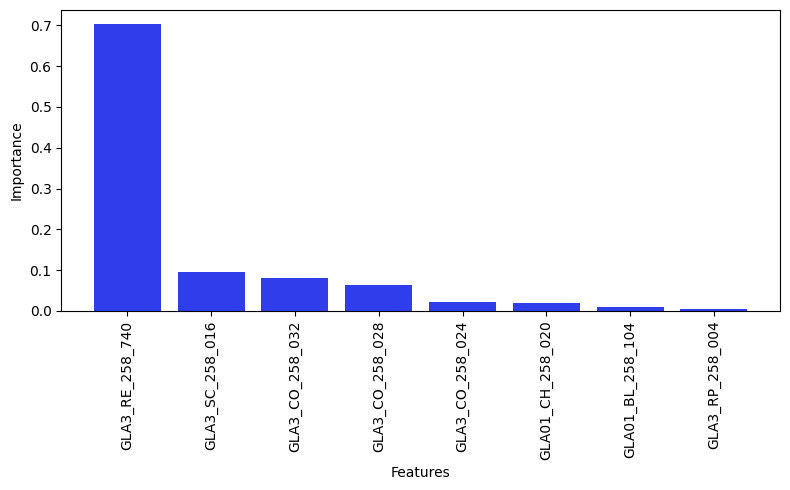

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Assuming you have trained a decision tree classifier and stored it in the variable 'dt_classifier'
feature_importance = model.feature_importances_

# Get the names of the features
feature_names = data.columns  # Replace with your actual feature names

# Sort the feature importance values and feature names in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot the feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(len(feature_importance)), sorted_feature_importance, align='center', color="#2F3EEA")
plt.xticks(range(len(feature_importance)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.title('Decision Tree Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
sorted_feature_importance

array([0.70216234, 0.09489777, 0.08163628, 0.06451849, 0.02309851,
       0.0197662 , 0.00922222, 0.0046982 ])

In [ ]:
feature_importance = model.feature_importances_

# Sort the feature importance values in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]

In [ ]:
feature_importance

array([0.00922222, 0.0197662 , 0.02309851, 0.06451849, 0.08163628,
       0.70216234, 0.0046982 , 0.09489777])

In [ ]:
model_generator = (model for model in [LogisticRegression(class_weight='balanced'),
                                    #    DecisionTreeClassifier(class_weight='balanced'),
                                       svm.SVC()])


In [ ]:
for model in model_generator:
    for i in imbalance_split:
        trainingModel(model, i[0], i[1], i[2], model.__class__.__name__)

LogisticRegression  +  undersample
Accuracy: 0.9456762749445676
              precision    recall  f1-score   support

 No downtime       0.97      0.96      0.97    117391
    downtime       0.87      0.88      0.87     31439

    accuracy                           0.95    148830
   macro avg       0.92      0.92      0.92    148830
weighted avg       0.95      0.95      0.95    148830

LogisticRegression  +  over_sample
Accuracy: 0.9461466102264329
              precision    recall  f1-score   support

 No downtime       0.97      0.96      0.97    117391
    downtime       0.87      0.88      0.87     31439

    accuracy                           0.95    148830
   macro avg       0.92      0.92      0.92    148830
weighted avg       0.95      0.95      0.95    148830



# LSTM Multivariate + Univariate


In [ ]:
data_bck = data.copy()

In [ ]:
data = data_bck.copy()

In [ ]:
data.drop(columns=['trigger', 'downtime'], inplace=True)

In [ ]:
data=pd.DataFrame(data[:400000]["GLA3_RE_258_740"])
data

,GLA3_RE_258_740
DateTime,
2022-01-01 20:16:00,-2.262165
2022-01-01 20:17:00,-2.262195
2022-01-01 20:18:00,-2.262206
2022-01-01 20:19:00,-2.262327
2022-01-01 20:20:00,-2.262449
...,...
2022-10-06 14:51:00,0.709428
2022-10-06 14:52:00,0.752503
2022-10-06 14:53:00,0.749536


In [ ]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.85)]
test_df = data[int(n*0.85):]

## Multivariate LSTM

In [ ]:
window_generator = WindowGenerator(input_width=30, label_width=1,
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df,
                                   label_columns=data.columns)

In [ ]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(val_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 8), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 8), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 8), dtype=tf.float64, name=None))>


In [ ]:
# model = Sequential()
# model.add(LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1]), return_sequences = True))
# model.add(LSTM(32, return_sequences = False))
# model.add(RepeatVector(window_generator.input_width))
# model.add(LSTM(32, return_sequences = True))
# model.add(LSTM(64, return_sequences = True))
# model.add(TimeDistributed(Dense(len(data.columns))))


In [ ]:
# model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 64)                18688     
                                                                 
 repeat_vector_17 (RepeatVec  (None, 30, 64)           0         
 tor)                                                            
                                                                 
 lstm_69 (LSTM)              (None, 30, 32)            12416     
                                                                 
 lstm_70 (LSTM)              (None, 30, 64)            24832     
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 8)            520       
 stributed)                                                      
                                                                 
 dense_19 (Dense)            (None, 30, 8)           

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(len(data.columns))
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                18688     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 19,208
Trainable params: 19,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mse',
              optimizer='adam',
              metrics='mse')


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
history = model.fit(train_ds, epochs=12, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/12
4375/4375 [==============================] - 248s 55ms/step - loss: 0.3792 - mse: 0.3792 - val_loss: 0.5446 - val_mse: 0.5446
Epoch 2/12
4375/4375 [==============================] - 239s 55ms/step - loss: 0.2634 - mse: 0.2634 - val_loss: 0.3655 - val_mse: 0.3655
Epoch 3/12
4375/4375 [==============================] - 243s 56ms/step - loss: 0.2339 - mse: 0.2339 - val_loss: 0.3411 - val_mse: 0.3411
Epoch 4/12
4375/4375 [==============================] - 245s 56ms/step - loss: 0.2187 - mse: 0.2187 - val_loss: 0.3234 - val_mse: 0.3234
Epoch 5/12
4375/4375 [==============================] - 244s 56ms/step - loss: 0.2073 - mse: 0.2073 - val_loss: 0.3076 - val_mse: 0.3076
Epoch 6/12
4375/4375 [==============================] - 241s 55ms/step - loss: 0.2001 - mse: 0.2001 - val_loss: 0.2701 - val_mse: 0.2701
Epoch 7/12
4375/4375 [==============================] - 242s 55ms/step - loss: 0.2015 - mse: 0.2015 - val_loss: 0.2636 - val_mse: 0.2636
Epoch 8/12
4375/4375 [===================

In [ ]:
y_pred = model.predict(test_ds)

937/937 [==============================] - 21s 22ms/step


In [ ]:
len(y_pred)

59966

In [ ]:
test_df_inverse = pd.DataFrame(scaler.inverse_transform(test_df[-len(y_pred):]), columns=test_df.columns, index=test_df[-len(y_pred):].index )
y_pred_inverse =  pd.DataFrame(scaler.inverse_transform(y_pred), columns=test_df.columns, index=test_df[-len(y_pred):].index )

ValueError: ignored

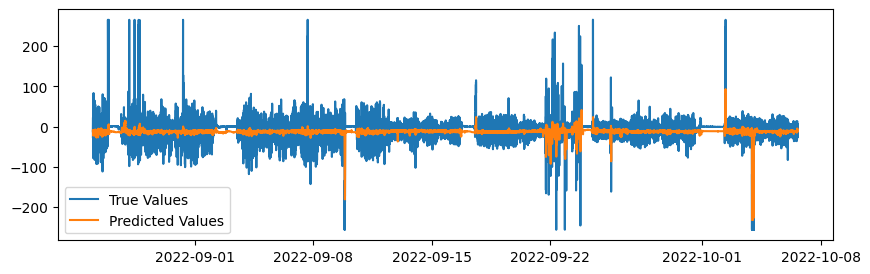

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(test_df_inverse['GLA3_CO_258_024'], label='True Values')
plt.plot(y_pred_inverse['GLA3_CO_258_024'], label='Predicted Values')
plt.legend()
plt.show()

In [ ]:
def LSTM_evaluation(test_ds, test_df):

    y_pred = model.predict(test_ds)
    y_true_inverse = pd.DataFrame(scaler.inverse_transform(test_df[-len(y_pred):]), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    y_pred_inverse =  pd.DataFrame(scaler.inverse_transform(y_pred), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    result = pd.DataFrame(columns=test_df.columns, index=['MSE', 'MAE'])

    print(y_true_inverse)
    print(y_pred_inverse)

    for i in range(len(test_df.columns)):
        result.loc['MSE', test_df.columns[i]] = mean_squared_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i], squared=False).round(3)
        result.loc['MAE', test_df.columns[i]] = mean_absolute_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i]).round(3)
    return result



In [ ]:
result = LSTM_evaluation(test_ds, test_df)
result

937/937 [==============================] - 35s 35ms/step


ValueError: ignored

## Univariate LSTM

In [ ]:
data = data["GLA3_RE_258_740"]

In [ ]:
window_generator = WindowGenerator(input_width=30, label_width=1,
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df,
                                   label_columns=["GLA3_RE_258_740"])

In [ ]:
train_df

DateTime
2022-01-01 20:16:00   -2.262165
2022-01-01 20:17:00   -2.262195
2022-01-01 20:18:00   -2.262206
2022-01-01 20:19:00   -2.262327
2022-01-01 20:20:00   -2.262449
                         ...   
2022-07-15 06:51:00   -2.260988
2022-07-15 06:52:00   -2.261153
2022-07-15 06:53:00   -2.259857
2022-07-15 06:54:00   -2.259742
2022-07-15 06:55:00   -2.260174
Name: GLA3_RE_258_740, Length: 280000, dtype: float64

In [ ]:
train_ds = window_generator.make_dataset(pd.DataFrame(train_df))
val_ds = window_generator.make_dataset(pd.DataFrame(val_df))
test_ds = window_generator.make_dataset(pd.DataFrame(test_df))

features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1)
])

In [ ]:
model.compile(loss='mse',
              optimizer='adam',
              metrics='mse')


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(train_ds, epochs=12, validation_data=val_ds, callbacks=[early_stop])


Epoch 1/12
4375/4375 [==============================] - 152s 34ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 2/12
4375/4375 [==============================] - 129s 29ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 3/12
4375/4375 [==============================] - 126s 29ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0275 - val_mse: 0.0275
Epoch 4/12
4375/4375 [==============================] - 136s 31ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 5/12
4375/4375 [==============================] - 126s 29ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 6/12
4375/4375 [==============================] - 137s 31ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 7/12
4375/4375 [==============================] - 136s 31ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 8/12
4375/4375 [===================

In [ ]:
y_pred = model.predict(test_ds)


937/937 [==============================] - 18s 20ms/step


In [ ]:
  y_true = np.array(test_df[-len(y_pred):]["GLA3_RE_258_740"])

In [ ]:
y_pred

array([[0.5644054 ],
       [0.6012047 ],
       [0.5908694 ],
       ...,
       [0.6990121 ],
       [0.6951623 ],
       [0.68682534]], dtype=float32)

In [ ]:
y_true

array([0.45575263, 0.39659169, 0.37388414, ..., 0.74953592, 0.6866797 ,
       0.72425214])

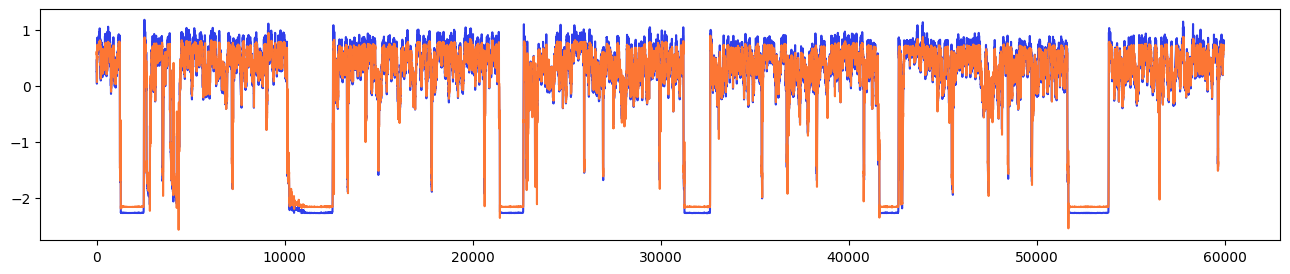

In [ ]:
plt.figure(figsize = (16,3))
plt.plot(y_true, label='y_true', color = '#2F3EEA')
plt.plot(y_pred, label='y_pred', color = '#FC7634')

In [ ]:
window_generator = WindowGenerator(input_width=30, label_width=1,
                                    shift=5, train_df=train_df, val_df=val_df, test_df=test_df,
                                    label_columns=['GLA01_BL_258_104'])

In [ ]:
  train_ds = window_generator.make_dataset(train_df)
  val_ds = window_generator.make_dataset(val_df)
  test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
models = []
for column in data.columns:
  window_generator = WindowGenerator(input_width=30, label_width=1,
                                    shift=10, train_df=train_df, val_df=val_df, test_df=test_df,
                                    label_columns=[column])

  train_ds = window_generator.make_dataset(train_df)
  val_ds = window_generator.make_dataset(val_df)
  test_ds = window_generator.make_dataset(test_df)

  model = Sequential([
    LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1)
  ])

  model.compile(loss='mse',
              optimizer='adam',
              metrics='mse')

  early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
  history = model.fit(train_ds, epochs=12, validation_data=val_ds, callbacks=[early_stop])

  scaler2 = StandardScaler()
  df[column] = scaler2.fit_transform(df[column].values.reshape(-1, 1))

  y_pred = model.predict(test_ds)
  y_true = test_df[column][-len(y_pred):]

  model_info = {
      'column': column,
      'y_true': y_true,
      'y_pred': y_pred,
      }

  models.append(model_info)

features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 8), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 30, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/12
4375/4375 [==============================] - 154s 34ms/step - loss: 0.9377 - mse: 0.9377 - val_loss: 0.7262 - val_mse: 0.7262
Epoch 2/12
4375/4375 [==============================] - 148s 34ms/step - loss: 0.9169 - mse: 0.9169 - val_loss: 0.6978 - val_mse: 0.6978
Epoch 3/12
4375/4375 [=======================

In [ ]:
for model in models:
  model['y_true'] = model.get('y_true').values
  model['y_pred'] = model.get('y_pred').flatten()



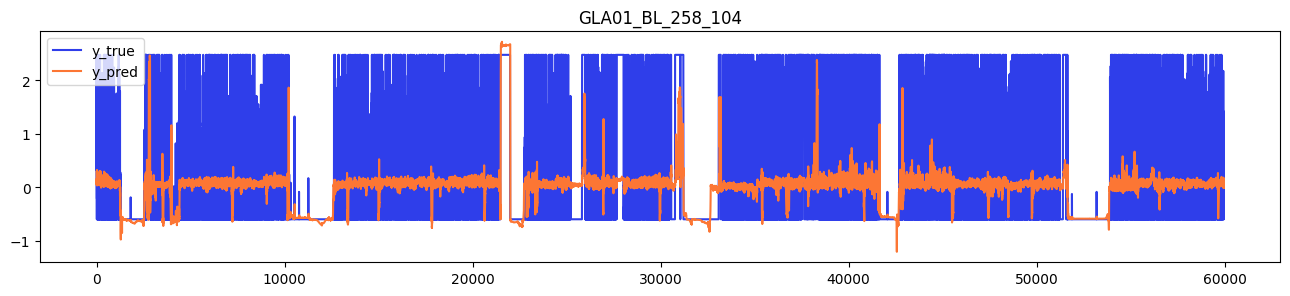

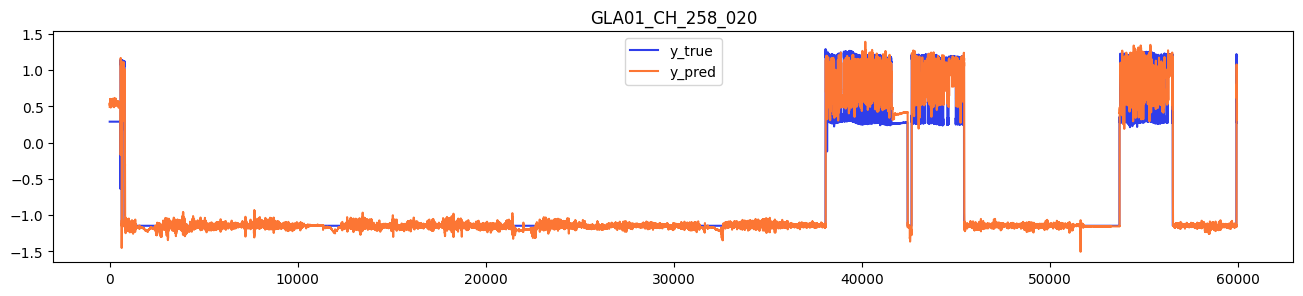

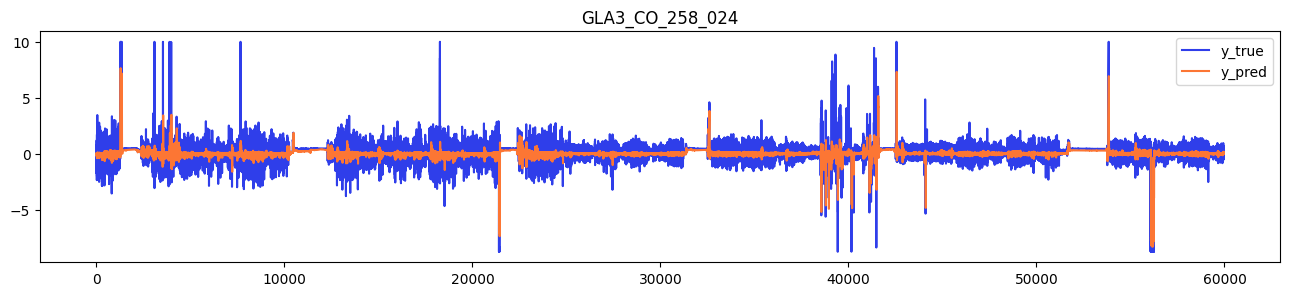

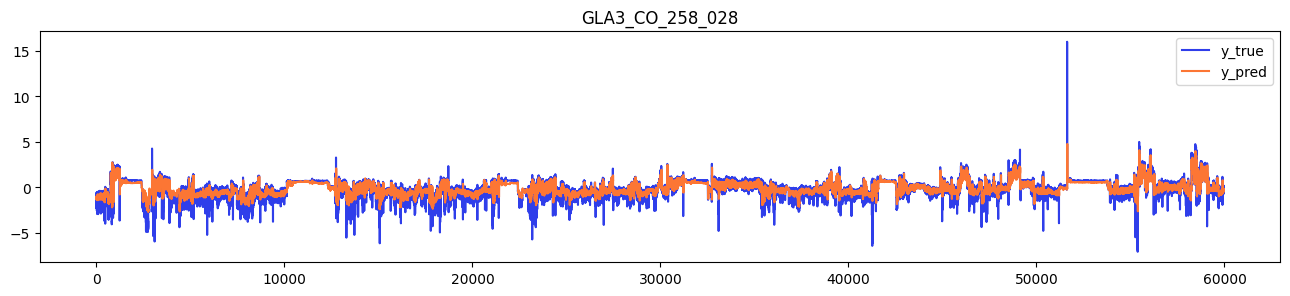

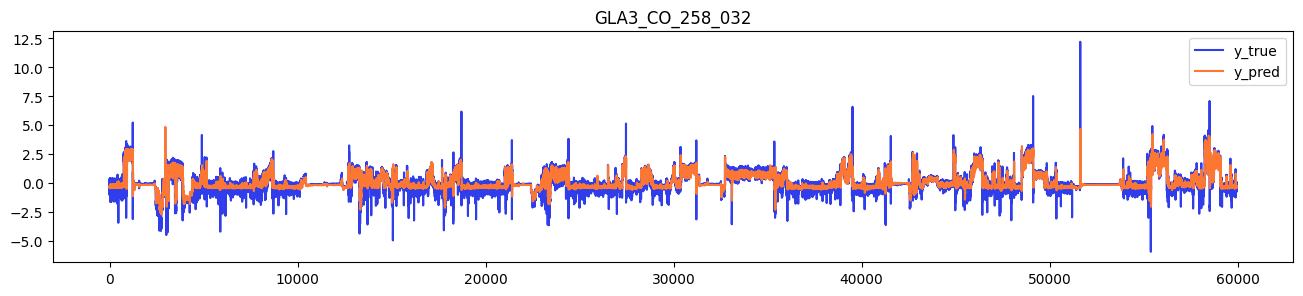

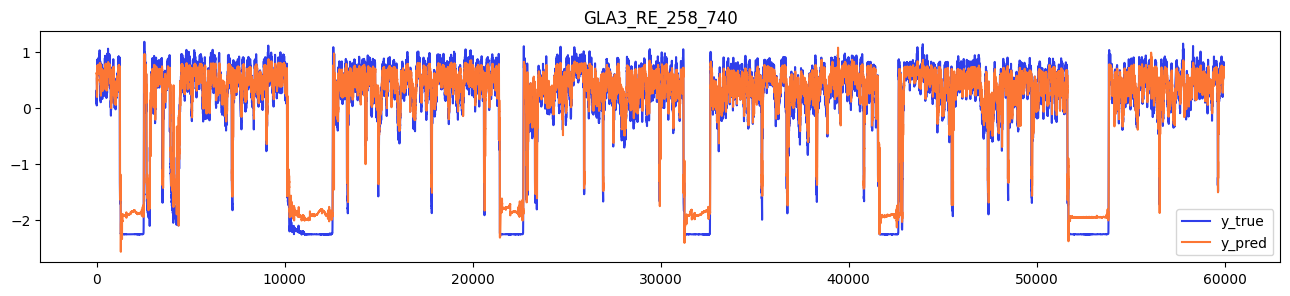

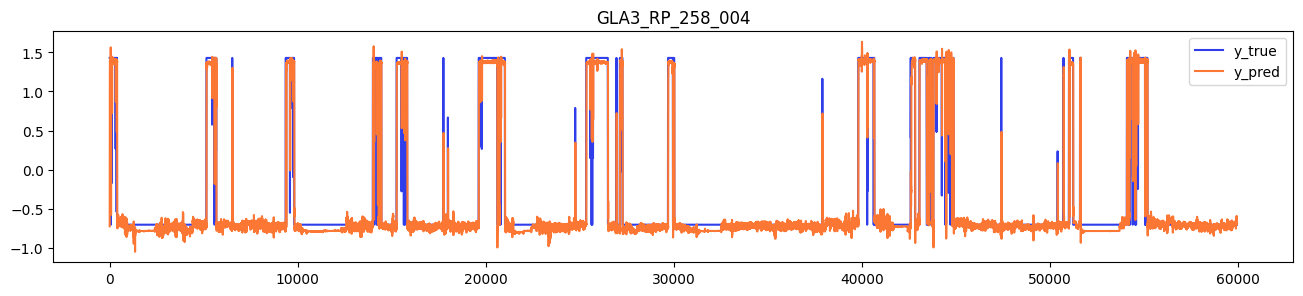

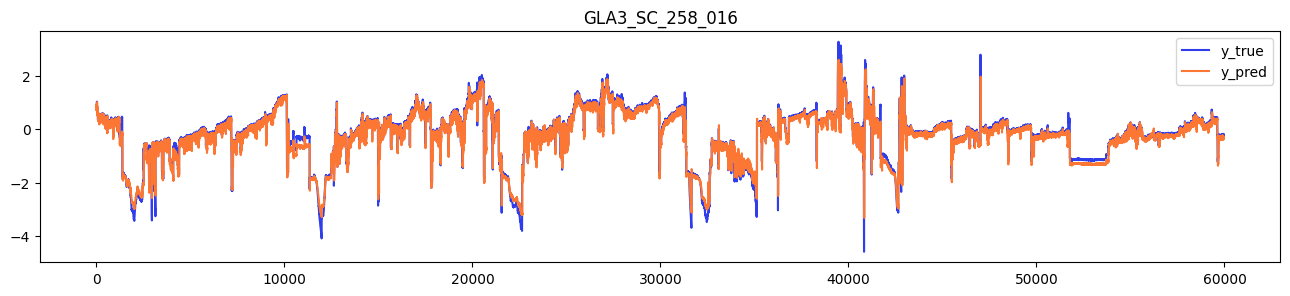

In [ ]:
for model in models:
    column = model['column']
    y_true = model['y_true']
    y_pred = model['y_pred']

    plt.figure(figsize = (16,3))
    plt.plot(y_true, label='y_true', color = '#2F3EEA')
    plt.plot(y_pred, label='y_pred', color = '#FC7634')
    plt.title(column)
    plt.legend()
    plt.show()

In [ ]:
mdel_bck = models.copy()

In [ ]:
for i, model in enumerate(models):
    model['y_true'] = model['y_true'] * scaler.scale_[i] + scaler.mean_[i]
    model['y_pred'] = model['y_pred'] * scaler.scale_[i] + scaler.mean_[i]

In [ ]:
def LSTM_evaluation(model, test_ds, test_df):

    y_pred = model.predict(test_ds)
    y_true_inverse = pd.DataFrame(scaler.inverse_transform(test_df[-len(y_pred):]), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    y_pred_inverse =  pd.DataFrame(scaler.inverse_transform(y_pred), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    result = pd.DataFrame(columns=test_df.columns, index=['MSE', 'MAE'])

    print(y_true_inverse)
    print(y_pred_inverse)

    for i in range(len(test_df.columns)):
        result.loc['MSE', test_df.columns[i]] = mean_squared_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i], squared=False).round(3)
        result.loc['MAE', test_df.columns[i]] = mean_absolute_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i]).round(3)
    return result

In [ ]:

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
for model in models:
    column = model['column']
    y_true = model['y_true']
    y_pred = model['y_pred']

    rmse = calculate_rmse(y_true, y_pred).round(3)
    mae = calculate_mae(y_true, y_pred).round(3)
    mape = calculate_mape(y_true, y_pred).round(3)

    print(f"Metrics for column {column}:")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print()

Metrics for column GLA01_BL_258_104:
RMSE: 13.631
MAE: 9.385
MAPE: inf

Metrics for column GLA01_CH_258_020:
RMSE: 1.91
MAE: 0.81
MAPE: 1.0118701345825978e+16

Metrics for column GLA3_CO_258_024:
RMSE: 19.251
MAE: 10.883
MAPE: inf

Metrics for column GLA3_CO_258_028:
RMSE: 10.253
MAE: 6.976
MAPE: inf

Metrics for column GLA3_CO_258_032:
RMSE: 10.997
MAE: 6.987
MAPE: 10217.415

Metrics for column GLA3_RE_258_740:
RMSE: 0.663
MAE: 0.479
MAPE: inf

Metrics for column GLA3_RP_258_004:
RMSE: 10.841
MAE: 3.218
MAPE: inf

Metrics for column GLA3_SC_258_016:
RMSE: 114.737
MAE: 67.257
MAPE: 691079.525



<ipython-input-30-b3299bde4226>:8: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## DL classifier

In [ ]:
len(X)

49591

In [ ]:
data_bck['downtime']

In [ ]:
data_bck['downtime'][int(n*0.9):]

DateTime
2022-11-07 21:44:00    1
2022-11-07 21:45:00    1
2022-11-07 21:46:00    1
2022-11-07 21:47:00    1
2022-11-07 21:48:00    1
                      ..
2022-12-12 08:29:00    0
2022-12-12 08:30:00    0
2022-12-12 08:31:00    0
2022-12-12 08:32:00    0
2022-12-12 08:33:00    0
Freq: T, Name: downtime, Length: 49610, dtype: int64

In [ ]:
X = y_pred
y= data_bck['downtime'][int(n*0.9):][-len(y_pred):]

In [ ]:
len(X)

49591

In [ ]:
len(y)

49591

In [ ]:
results = pd.DataFrame(X, y, columns = data.columns).reset_index()
results

,downtime,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016
0,1,-0.555549,-1.032499,0.022279,0.582306,-0.118933,-1.698371,-0.036606,-2.183590,-0.771056,-1.163524
1,1,-0.556008,-1.032771,0.021866,0.575687,-0.122335,-1.699219,-0.036927,-2.185005,-0.771454,-1.160293
2,1,-0.555703,-1.034323,0.023551,0.582349,-0.117968,-1.700330,-0.036595,-2.185646,-0.771448,-1.165010
3,1,-0.556455,-1.033242,0.022923,0.584759,-0.119090,-1.701183,-0.036238,-2.185170,-0.771250,-1.162949
4,1,-0.557979,-1.033673,0.024054,0.584042,-0.119320,-1.691992,-0.035389,-2.183252,-0.771329,-1.154702
...,...,...,...,...,...,...,...,...,...,...,...
49586,0,0.240702,-1.076161,0.171621,0.449303,-0.095059,1.021557,-0.046006,0.585065,-0.647898,-1.272743
49587,0,0.192442,-1.089465,0.170316,0.456300,-0.096508,0.992563,-0.039831,0.553739,-0.651798,-1.253856
49588,0,0.149694,-1.110523,0.176633,0.431873,-0.110446,0.909994,-0.029866,0.504157,-0.652259,-1.273659
49589,0,0.116304,-1.097338,0.178422,0.400707,-0.127753,0.873316,-0.039104,0.534321,-0.652987,-1.277484


In [ ]:
X = results.iloc[:, 1:].values.reshape(-1, 1)
X

array([[-0.5555486 ],
       [-1.0324993 ],
       [ 0.02227858],
       ...,
       [ 0.4974556 ],
       [-0.67108333],
       [-1.2960162 ]], dtype=float32)

In [ ]:
X = y_pred

In [ ]:
y = data_bck['downtime'][int(n*0.9):]

In [ ]:
len(y)

49610

In [ ]:
len(X)

49591

In [ ]:
y


DateTime
2022-11-07 21:44:00    1
2022-11-07 21:45:00    1
2022-11-07 21:46:00    1
2022-11-07 21:47:00    1
2022-11-07 21:48:00    1
                      ..
2022-12-12 08:29:00    0
2022-12-12 08:30:00    0
2022-12-12 08:31:00    0
2022-12-12 08:32:00    0
2022-12-12 08:33:00    0
Freq: T, Name: downtime, Length: 49610, dtype: int64

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X = y_pred
y = y[-len(y_pred):].values


split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=False))
model.add(layers.Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32)


y_pred = model.predict(X_test)


y_pred_binary = np.round(y_pred)


first_downtime = np.argmax(y_pred_binary, axis=1)


accuracy = np.mean(first_downtime == y_test.squeeze())

Epoch 1/10
1240/1240 [==============================] - 17s 10ms/step - loss: 0.1041 - accuracy: 0.9727
Epoch 2/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0816 - accuracy: 0.9760
Epoch 3/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0722 - accuracy: 0.9789
Epoch 4/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0662 - accuracy: 0.9807
Epoch 5/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0623 - accuracy: 0.9822
Epoch 6/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0594 - accuracy: 0.9830
Epoch 7/10
1240/1240 [==============================] - 13s 10ms/step - loss: 0.0565 - accuracy: 0.9836
Epoch 8/10
1240/1240 [==============================] - 13s 10ms/step - loss: 0.0533 - accuracy: 0.9845
Epoch 9/10
1240/1240 [==============================] - 12s 10ms/step - loss: 0.0486 - accuracy: 0.9860
Epoch 10/10
310/310 [==============================] - 2s 5ms/st

In [ ]:
y_pred_binary

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

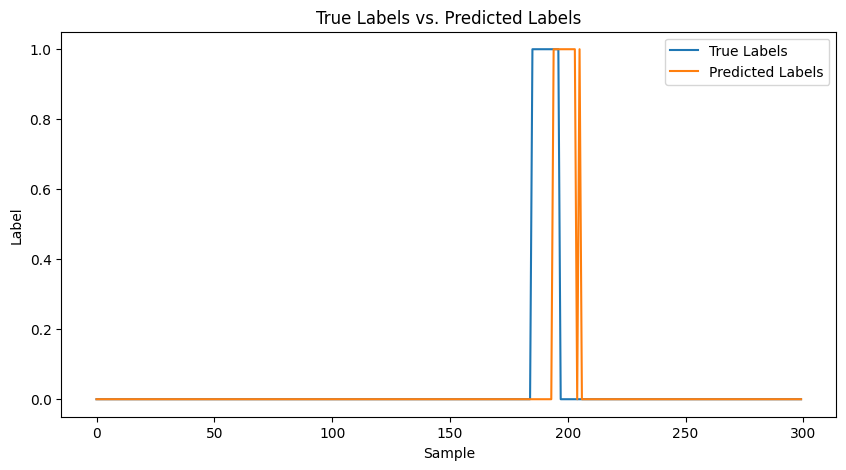

In [ ]:
import matplotlib.pyplot as plt


y_test = y_test.squeeze()
y_pred_binary = y_pred_binary.squeeze()


plt.figure(figsize=(10, 5))
plt.plot(y_test[700:1000], label='True Labels')
plt.plot(y_pred_binary[700:1000], label='Predicted Labels')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('True Labels vs. Predicted Labels')
plt.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(20,15))


ax.plot(y_test[875:950], color='blue', label='real')
ax.plot(y_pred_binary[875:950], color='red', label='pred')

plugins.connect(fig, plugins.Zoom())

mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


# Machine Learning models

In [ ]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger_0.0,trigger_1.0,downtime_0.0,downtime_1.0
2020-01-01 20:16:00,-1.379979,0.957810,0.214982,NaN,NaN,NaN,NaN
2020-01-01 20:17:00,-1.380610,0.957678,0.217594,NaN,NaN,NaN,NaN
2020-01-01 20:18:00,-1.384261,0.958835,0.216490,NaN,NaN,NaN,NaN
2020-01-01 20:19:00,-1.378179,0.959315,0.211890,NaN,NaN,NaN,NaN
2020-01-01 20:20:00,-1.378295,0.957694,0.211246,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1580413,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580414,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580415,NaN,NaN,NaN,1.0,0.0,0.0,1.0
1580416,NaN,NaN,NaN,1.0,0.0,0.0,1.0


In [ ]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [ ]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [ ]:
numerical_features = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231']

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
data = df.copy()

In [ ]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [ ]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['downtime'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [ ]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.9783251967777359


In [ ]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.98      0.99   7531904
 no-downtime       0.91      0.99      0.95   1928897

    accuracy                           0.98   9460801
   macro avg       0.95      0.98      0.97   9460801
weighted avg       0.98      0.98      0.98   9460801



In [ ]:
results = pd.DataFrame(y_test, y_pred)
results = results.reset_index()
results = results.rename(columns={'index':'y_test', 0:'y_pred'})
results.head()

,y_test,y_pred
0,1,1
1,0,0
2,0,0
3,1,1
4,0,0


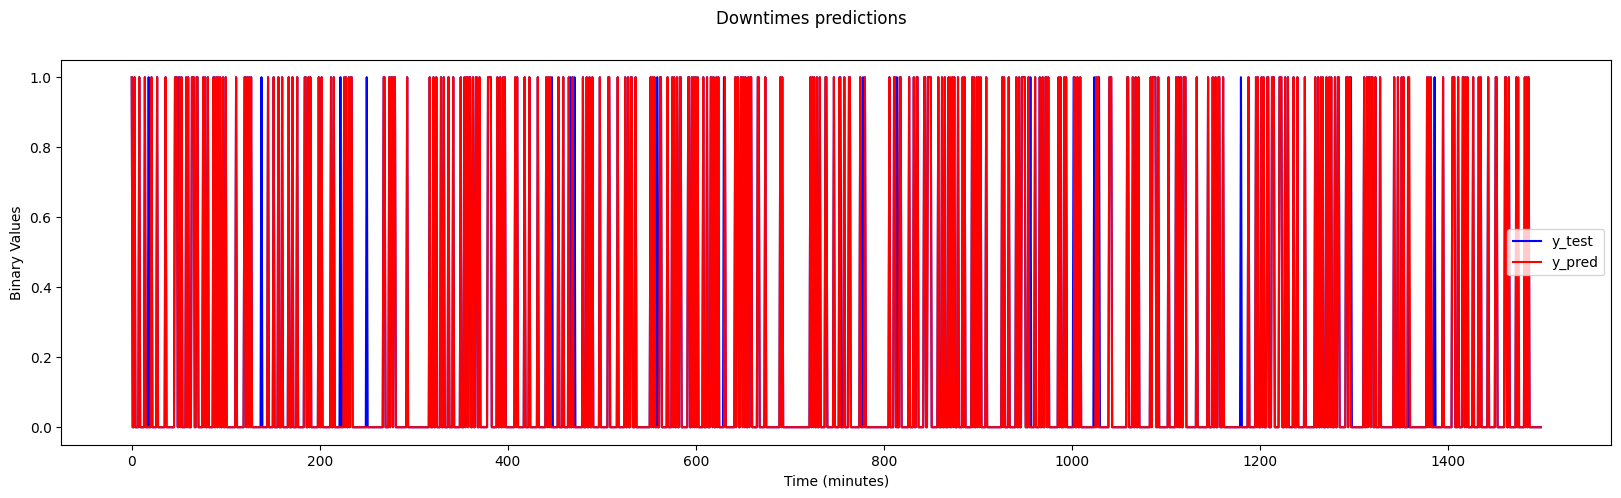

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

# plot the first column on the first subplot
results['y_test'][:1500].plot(ax=ax, color='blue', label='y_test')
results['y_pred'][:1500].plot(ax=ax, color='red', label='y_pred')
ax.set_ylabel('Binary Values')

# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes predictions')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

# LSTM LAG Example

In [ ]:
data

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,
2022-01-01 20:16:00,-0.599254,-1.146579,-2.191962,0.696636,-0.035536,-2.262165,-0.70184,-1.134385,0,1
2022-01-01 20:17:00,-0.599254,-1.146579,-2.193082,0.700126,-0.037347,-2.262195,-0.70184,-1.128581,0,1
2022-01-01 20:18:00,-0.599254,-1.146579,-2.192925,0.700285,-0.037798,-2.262206,-0.70184,-1.135094,0,1
2022-01-01 20:19:00,-0.599254,-1.146579,-2.190918,0.692158,-0.041969,-2.262327,-0.70184,-1.132376,0,1
2022-01-01 20:20:00,-0.599254,-1.146579,-2.191290,0.696930,-0.039375,-2.262449,-0.70184,-1.129510,0,1
...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:29:00,-0.599254,-1.146579,0.157296,0.893576,-0.222329,0.799855,-0.70184,-1.587910,0,0
2022-12-12 08:30:00,-0.599254,-1.146579,0.268279,0.835884,-0.207674,0.812473,-0.70184,-1.661883,0,0
2022-12-12 08:31:00,-0.599254,-1.146579,0.168004,0.780759,-0.344151,0.820609,-0.70184,-1.700657,0,0


In [ ]:
neg, pos = np.bincount(data['downtime'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
total, pos, 100 * pos / total))

Examples:
    Total: 496098
    Positive: 105099 (21.19% of total)



In [ ]:
data = data.drop(columns=['trigger'])

In [ ]:
data=data[:400000]

In [ ]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.85)]
test_df = data[int(n*0.85):]

In [ ]:
test_df

,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,downtime
DateTime,,,,,,,,,
2022-08-25 22:56:00,0.425400,0.288163,-0.490801,-1.759760,-0.538110,0.533821,-0.70184,1.005533,0
2022-08-25 22:57:00,0.239100,0.288163,0.517294,-0.587171,0.405231,0.459049,-0.70184,0.985517,0
2022-08-25 22:58:00,0.681564,0.288163,0.098334,-0.815498,0.121278,0.430607,-0.70184,1.069551,0
2022-08-25 22:59:00,-0.599254,0.288163,0.458741,-2.098028,-0.874376,0.432692,-0.70184,0.980508,0
2022-08-25 23:00:00,0.169237,0.288163,0.086787,-2.140476,-0.903275,0.503753,-0.70184,1.015980,0
...,...,...,...,...,...,...,...,...,...
2022-10-06 14:51:00,-0.599254,0.825691,0.095899,0.067183,-0.037817,0.709428,-0.70184,-0.264732,0
2022-10-06 14:52:00,-0.452875,1.146573,0.646595,-0.512050,-0.511757,0.752503,-0.70184,-0.217507,0
2022-10-06 14:53:00,0.075518,1.208097,0.157349,-0.528684,-0.523474,0.749536,-0.70184,-0.268700,0


In [ ]:
window_generator = WindowGenerator(input_width=15, label_width=1,
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [ ]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 9), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 9), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 9), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [ ]:
weight_trigger = 400000 / (2 * 0.0015)
weight_downtime = 400000 / (2 * 0.95)

In [ ]:
weight_trigger

133333333.33333333

In [ ]:
import tensorflow.keras.backend as K

weight_trigger = 400000 / (2 * 0.0015)
weight_downtime = 400000 / (2 * 0.95)

def weighted_binary_crossentropy(weight_0, weight_1):
    def loss(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(), 1 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss_0 = weight_0 * (y_true * K.log(y_pred))
        loss_1 = weight_1 * ((1 - y_true) * K.log(1 - y_pred))
        return -K.mean(loss_0 + loss_1, axis=-1)
    return loss

In [ ]:
def custom_loss(y_true, y_pred):
    # Find the indices of the first three occurrences of 1 in the true labels
    true_indices = tf.where(tf.equal(y_true, 1))
    first_three_true_indices = true_indices[:3]

    # Extract the predictions up to the first three true indices
    pred_until_true = tf.gather(y_pred, first_three_true_indices)

    # Calculate the mean squared error (MSE) loss on the predictions up to the first three true indices
    mse_loss = tf.keras.losses.mean_squared_error(tf.gather(y_true, first_three_true_indices), pred_until_true)

    # # Calculate the false positive penalty
    false_positive_penalty = tf.reduce_mean(tf.square(tf.maximum(y_pred - y_true, 0)))

    # # Combine the MSE loss and false positive penalty
    total_loss = mse_loss + false_positive_penalty

    return total_loss


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [ ]:
weight_0 = 1 / 0.99985  # Weight for the negative class
weight_1 = 10*(1 / 0.0015)  # Weight for the positive class


# Compile the model with the weighted binary cross-entropy loss
model.compile(optimizer='adam', loss=weighted_binary_crossentropy(weight_0, weight_1), metrics=[tf.metrics.BinaryAccuracy()])

In [ ]:
model.compile(loss=custom_loss,
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.BinaryAccuracy()])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [ ]:
history = model.fit(train_ds, epochs=12, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/12
4375/4375 [==============================] - 130s 29ms/step - loss: 0.0371 - binary_accuracy: 0.9268 - val_loss: 0.0330 - val_binary_accuracy: 0.9814
Epoch 2/12
4375/4375 [==============================] - 122s 28ms/step - loss: 0.0333 - binary_accuracy: 0.9637 - val_loss: 0.0319 - val_binary_accuracy: 0.9858
Epoch 3/12
4375/4375 [==============================] - 116s 26ms/step - loss: 0.0325 - binary_accuracy: 0.9684 - val_loss: 0.0311 - val_binary_accuracy: 0.9847
Epoch 4/12
4375/4375 [==============================] - 111s 25ms/step - loss: 0.0318 - binary_accuracy: 0.9723 - val_loss: 0.0306 - val_binary_accuracy: 0.9867
Epoch 5/12
4375/4375 [==============================] - 114s 26ms/step - loss: 0.0313 - binary_accuracy: 0.9672 - val_loss: 0.0301 - val_binary_accuracy: 0.9820
Epoch 6/12
4375/4375 [==============================] - 115s 26ms/step - loss: 0.0306 - binary_accuracy: 0.9646 - val_loss: 0.0295 - val_binary_accuracy: 0.9687
Epoch 7/12
4375/4375 [============

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

938/938 [==============================] - 9s 10ms/step
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     45199
           1       0.80      0.97      0.87     14782

    accuracy                           0.93     59981
   macro avg       0.89      0.94      0.91     59981
weighted avg       0.94      0.93      0.93     59981



In [ ]:
y_pred = model.predict(test_ds)

938/938 [==============================] - 15s 15ms/step


In [ ]:
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)

In [ ]:
print(f'len test_df {len(y_true)} and len y_pred = {len(y_pred)}')

len test_df 39981 and len y_pred = 39981


In [ ]:
len(y_pred)

39981

In [ ]:
pred[:975]

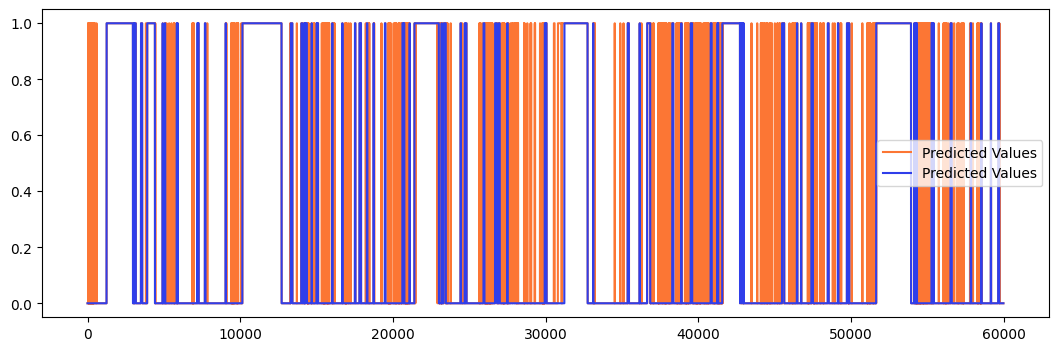

In [ ]:
plt.figure(figsize=(13, 4))
plt.plot(y_pred, label='Predicted Values', color='#FC7634' )
plt.plot(y_true, label='Predicted Values',  color = '#2F3EEA')
plt.legend()
plt.show()

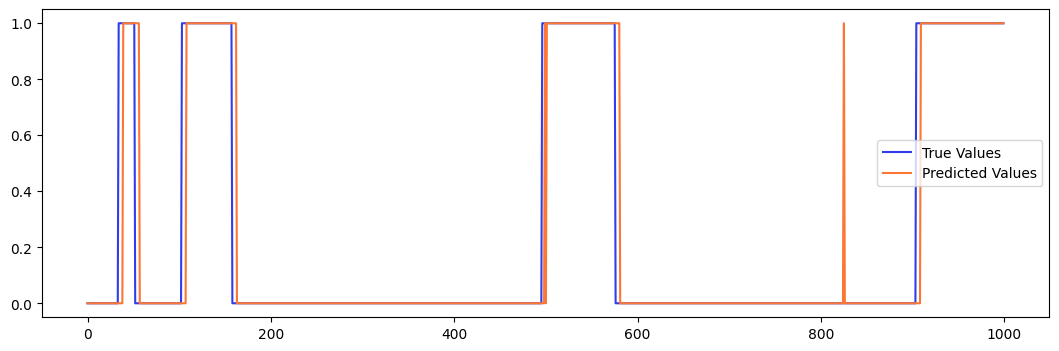

In [ ]:
plt.figure(figsize=(13, 4))
plt.plot(y_true[3000:4000], label='True Values',  color = '#2F3EEA')
plt.plot(y_pred[3000:4000], label='Predicted Values', color = '#FC7634')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)

1250/1250 [==============================] - 5s 4ms/step



Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [30/May/2023 17:53:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2023 17:53:44] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2023 17:53:44] "GET /mpld3.js HTTP/1.1" 200 -
127.0.0.1 - - [30/May/2023 17:53:44] code 404, message Not Found
127.0.0.1 - - [30/May/2023 17:53:44] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


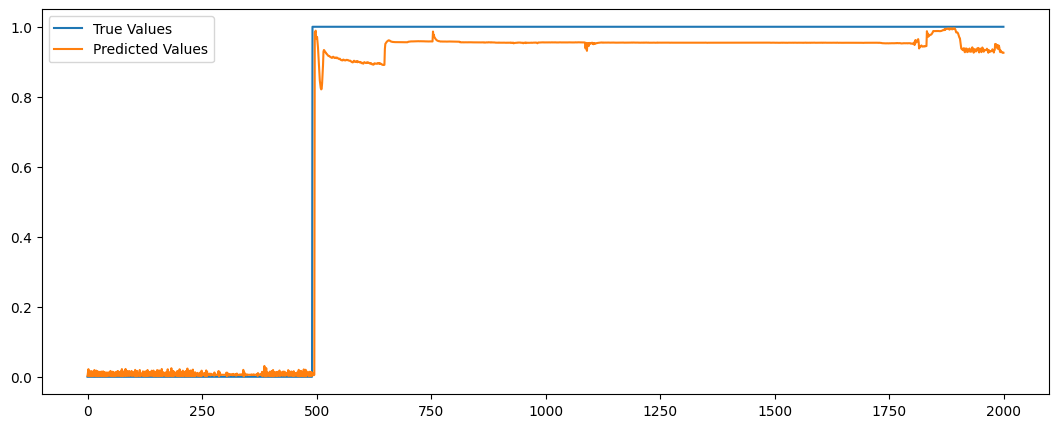

In [ ]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(y_true[1000:3000], label='True Values')
ax.plot(y_pred[1000:3000], label='Predicted Values')
ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()

In [ ]:
import numpy as np
from scipy.signal import correlate

y_pred_1d = y_pred.flatten()

corr = correlate(y_true, y_pred_1d)

# Find the lag with the maximum correlation
lag = np.argmax(corr) - len(y_true) + 1

print("Lag:", lag)

Lag: -5


# LSTM Pipeline for anomaly detection



data is all years pre-processed

## LSTM Forecaster

In [ ]:
data_without_downtime = pd.DataFrame(data['GLA3_RE_258_740'])

In [ ]:
data_without_downtime = data_without_downtime[:400000]

In [ ]:
n = len(data_without_downtime)
train_df = data_without_downtime[0:int(n*0.7)]
val_df = data_without_downtime[int(n*0.):int(n*0.85)]
test_df = data_without_downtime[int(n*0.85):]

In [ ]:
window_generator = WindowGenerator(input_width=15, label_width=1,
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['GLA3_RE_258_740'])

In [ ]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
model = Sequential([
    LSTM(64, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1)
])

In [ ]:
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(),
              metrics='mse')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
history = model.fit(train_ds, epochs=12, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/12
4375/4375 [==============================] - 128s 29ms/step - loss: 0.0416 - mse: 0.0416 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 2/12
4375/4375 [==============================] - 122s 28ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0252 - val_mse: 0.0252
Epoch 3/12
4375/4375 [==============================] - 118s 27ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 4/12
4375/4375 [==============================] - 118s 27ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 5/12
4375/4375 [==============================] - 118s 27ms/step - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 6/12
4375/4375 [==============================] - 120s 28ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 7/12
4375/4375 [==============================] - 123s 28ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 8/12
4375/4375 [===================

In [ ]:
y_pred = model.predict(test_ds)

938/938 [==============================] - 10s 10ms/step


In [ ]:
y_pred_inverse = scaler.mean_[5]
scaler.scale_[5]

2.5125669436970792

In [ ]:
test_df_inverse = pd.DataFrame((test_df[-len(y_pred):]) * scaler.scale_[5] + scaler.mean_[5] , columns=test_df.columns, index=test_df[-len(y_pred):].index )
y_pred_inverse =  pd.DataFrame((y_pred) * scaler.scale_[5] + scaler.mean_[5], columns=test_df.columns, index=test_df[-len(y_pred):].index )

In [ ]:
y_pred_inverse.rename(columns = {'GLA3_RE_258_740': 'GLA3_RE_258_740_pred'}, inplace=True)

In [ ]:
merged = y_pred_inverse.merge(test_df_inverse, how='left', right_index=True, left_index=True)

In [ ]:
merged_downtime = data_without_downtime.merge(df['downtime'], how='left', right_index=True, left_index=True)

In [ ]:
merged_downtime.drop(columns=['GLA3_RE_258_740'], inplace=True)

In [ ]:
merged_downtime

,GLA3_RE_258_740,downtime
DateTime,,
2022-01-01 20:16:00,-2.262165,1
2022-01-01 20:17:00,-2.262195,1
2022-01-01 20:18:00,-2.262206,1
2022-01-01 20:19:00,-2.262327,1
2022-01-01 20:20:00,-2.262449,1
...,...,...
2022-10-06 14:51:00,0.709428,0
2022-10-06 14:52:00,0.752503,0
2022-10-06 14:53:00,0.749536,0


## ML CLassifier

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Extract the feature values and downtime labels
X = merged_downtime["GLA3_RE_258_740_pred"].values.reshape(-1, 1)  # Reshape to (num_samples, num_features)
y = merged_downtime["downtime"].values

# Normalize the feature values using Min-Max scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Define sequence length and number of features
sequence_length = 3  # Adjust as per your requirements
num_features = 1  # Assuming only one feature (GLA3_RE_258_740_pred)

# Prepare the sequences
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y[i+sequence_length])

# Convert the sequences to numpy arrays
X = np.array(X_sequences)
y = np.array(y_sequences)

# Print the shapes of X and y
print("X.shape:", X.shape)
print("y.shape:", y.shape)


X.shape: (59978, 3, 1)
y.shape: (59978,)


In [ ]:
X[0]

array([[0.707696  ],
       [0.70992774],
       [0.7010965 ]], dtype=float32)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Prepare your dataset (assuming X contains the feature values and y contains the downtime labels)
# X.shape should be (num_samples, sequence_length, num_features)
# y.shape should be (num_samples,)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, num_features)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Make predictions
predictions = model.predict(X_test)


Epoch 1/10
1500/1500 [==============================] - 18s 9ms/step - loss: 0.2218 - accuracy: 0.9353 - val_loss: 0.1707 - val_accuracy: 0.9555
Epoch 2/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2108 - accuracy: 0.9380 - val_loss: 0.1676 - val_accuracy: 0.9563
Epoch 3/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2081 - accuracy: 0.9386 - val_loss: 0.1677 - val_accuracy: 0.9566
Epoch 4/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2066 - accuracy: 0.9392 - val_loss: 0.1648 - val_accuracy: 0.9571
Epoch 5/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2050 - accuracy: 0.9398 - val_loss: 0.1656 - val_accuracy: 0.9561
Epoch 6/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2036 - accuracy: 0.9399 - val_loss: 0.1653 - val_accuracy: 0.9566
Epoch 7/10
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2018 - accuracy: 0.9401 - val_loss: 0.1618 - val_ac

In [ ]:
len()

11995

In [ ]:
len(y_test)

11995

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 1, 1])

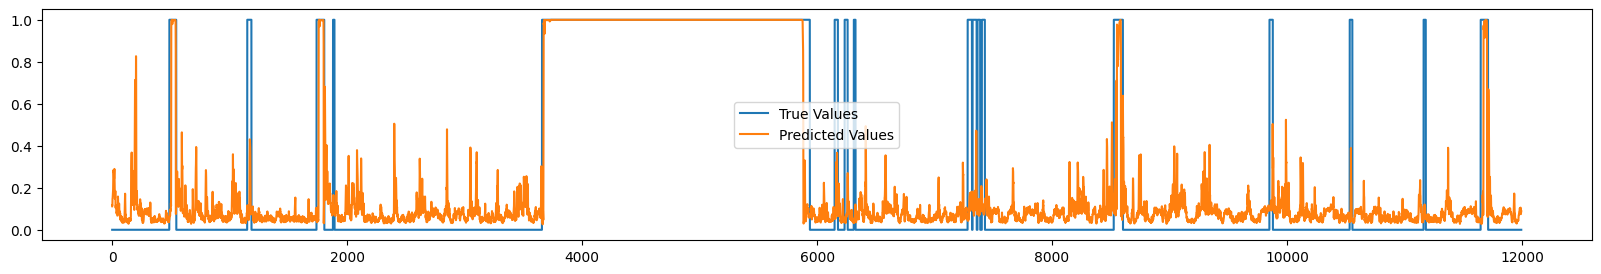

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.show()

## LSTMAE I

In [ ]:
merged_downtime.drop(columns=['downtime'], inplace=True)

In [ ]:
n = len(merged_downtime)
train_df = merged_downtime[0:int(n*0.7)]
val_df = merged_downtime[int(n*0.7):int(n*0.85)]
test_df = merged_downtime[int(n*0.85):]

In [ ]:
window_generator = WindowGenerator(input_width=15, label_width=1,
                                   shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['GLA3_RE_258_740'])

In [ ]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 1), dtype=float64)
ds is <_MapDataset element_spec=(TensorSpec(shape=(None, 15, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(window_generator.input_width, train_df.shape[1]), return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(RepeatVector(window_generator.input_width))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(64, return_sequences = True))
model.add(TimeDistributed(Dense( train_df.shape[1])))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 15, 64)            16896     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 15, 32)           0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 15, 64)            24832     
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 1)            65        
 tributed)                                            

In [ ]:
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(),
              metrics='mse')

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/10
4375/4375 [==============================] - 315s 70ms/step - loss: 0.0592 - mse: 0.0592 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 2/10
4375/4375 [==============================] - 299s 68ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0469 - val_mse: 0.0469
Epoch 3/10
4375/4375 [==============================] - 297s 68ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 4/10
4375/4375 [==============================] - 299s 68ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0345 - val_mse: 0.0345
Epoch 5/10
4375/4375 [==============================] - 299s 68ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 6/10
4375/4375 [==============================] - 301s 69ms/step - loss: 0.0225 - mse: 0.0225 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 7/10
4375/4375 [==============================] - 299s 68ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 8/10
4375/4375 [===================

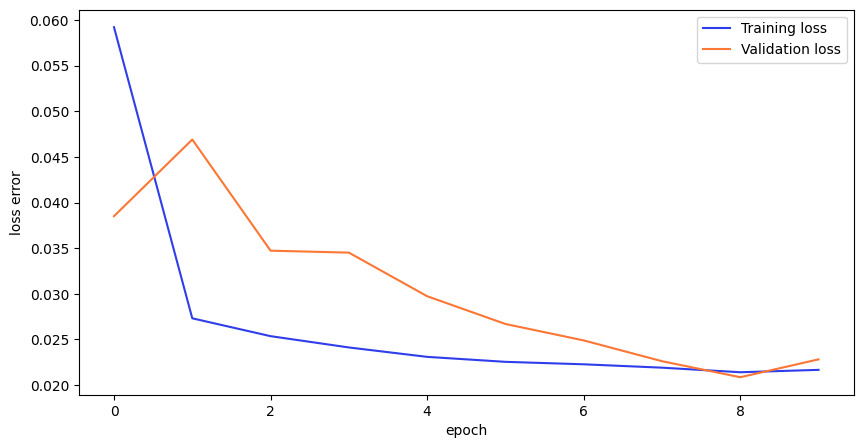

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], label='Training loss', color='#2F3EEA')
plt.plot(history.history['val_loss'], label='Validation loss', color='#FC7634')
plt.xlabel("epoch")
plt.ylabel("loss error")
plt.legend()


In [ ]:
y_pred = model.predict(test_ds)

938/938 [==============================] - 36s 33ms/step


In [ ]:
test_df_reshape = test_df[-len(y_pred):]

In [ ]:
y_pred.shape

(59981, 15, 1)

In [ ]:
first_step_y_pred = y_pred[:, 0, :]
first_step_y_pred.shape

(59981, 1)

In [ ]:
testMAE = np.mean(np.abs(first_step_y_pred - test_df_reshape.values ), axis=1)

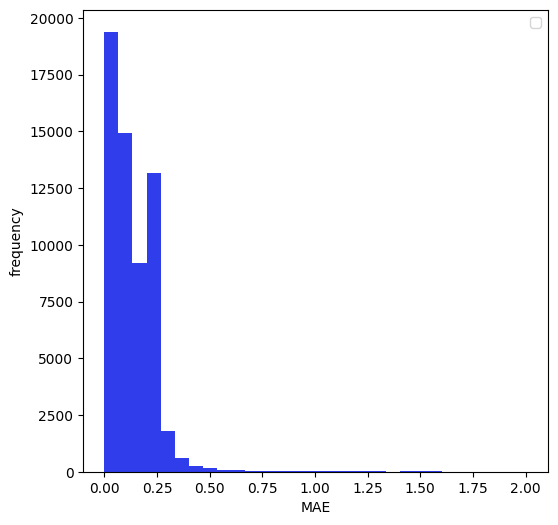

In [ ]:
plt.figure(figsize = (6,6))
plt.hist(testMAE, bins=30, color='#2F3EEA')
plt.xlabel("MAE")
plt.ylabel("frequency")
plt.legend()


(array([1.9393e+04, 1.4928e+04, 9.2160e+03, 1.3178e+04, 1.7820e+03,
        5.8800e+02, 2.5700e+02, 1.5500e+02, 8.2000e+01, 7.3000e+01,
        4.3000e+01, 3.3000e+01, 2.8000e+01, 2.5000e+01, 3.6000e+01,
        3.4000e+01, 1.6000e+01, 1.9000e+01, 1.6000e+01, 1.4000e+01,
        9.0000e+00, 1.3000e+01, 1.0000e+01, 1.4000e+01, 8.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1.01408637e-05, 6.69065411e-02, 1.33802941e-01, 2.00699342e-01,
        2.67595742e-01, 3.34492142e-01, 4.01388542e-01, 4.68284943e-01,
        5.35181343e-01, 6.02077743e-01, 6.68974143e-01, 7.35870544e-01,
        8.02766944e-01, 8.69663344e-01, 9.36559745e-01, 1.00345614e+00,
        1.07035255e+00, 1.13724895e+00, 1.20414535e+00, 1.27104175e+00,
        1.33793815e+00, 1.40483455e+00, 1.47173095e+00, 1.53862735e+00,
        1.60552375e+00, 1.67242015e+00, 1.73931655e+00, 1.80621295e+00,
        1.87310935e+00, 1.94000575e+00, 2.00690215e+00]),
 <BarContainer object of 30 

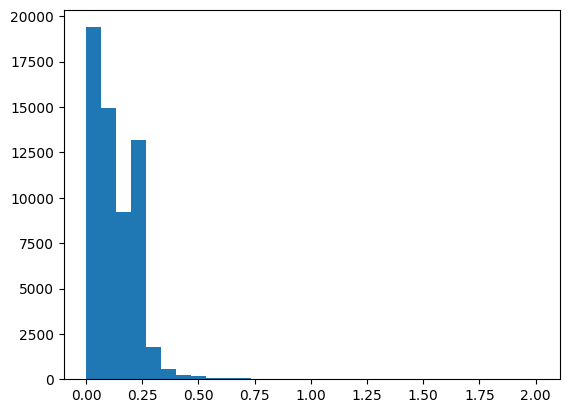

In [ ]:
plt.hist(testMAE, bins=30)

In [ ]:
df_reconstruct = pd.DataFrame((test_df_reshape), columns=test_df.columns, index=test_df[-len(y_pred):].index)
df_reconstruct['MAE'] = testMAE
df_reconstruct


,GLA3_RE_258_740,MAE
DateTime,,
2022-08-25 23:15:00,0.673689,0.034545
2022-08-25 23:16:00,0.557462,0.082015
2022-08-25 23:17:00,0.528981,0.095412
2022-08-25 23:18:00,0.510951,0.137209
2022-08-25 23:19:00,0.552337,0.089223
...,...,...
2022-10-06 14:51:00,0.709428,0.016036
2022-10-06 14:52:00,0.752503,0.060692
2022-10-06 14:53:00,0.749536,0.055719


In [ ]:
df_reconstruct['moving_average'] = df_reconstruct['MAE'].rolling(15).mean()
df_reconstruct['std'] = df_reconstruct['MAE'].rolling(15).std()
df_reconstruct.dropna(how="any", inplace=True)
df_reconstruct

,GLA3_RE_258_740,MAE,moving_average,std
DateTime,,,,
2022-08-25 23:29:00,0.552468,0.027783,0.073152,0.049073
2022-08-25 23:30:00,0.455753,0.112896,0.078376,0.048839
2022-08-25 23:31:00,0.396592,0.197072,0.086046,0.057685
2022-08-25 23:32:00,0.373884,0.209492,0.093651,0.065938
2022-08-25 23:33:00,0.348048,0.256064,0.101575,0.077648
...,...,...,...,...
2022-10-06 14:51:00,0.709428,0.016036,0.071220,0.056880
2022-10-06 14:52:00,0.752503,0.060692,0.071260,0.056871
2022-10-06 14:53:00,0.749536,0.055719,0.070918,0.056954


In [ ]:
df_reconstruct['max_MAE'] = df_reconstruct.apply(lambda x: x['moving_average'] + 3*x['std'], axis=1)

In [ ]:
df_reconstruct['outlier'] = df_reconstruct.apply(lambda x: 1 if x['MAE'] >  x['max_MAE'] else 0, axis=1)


In [ ]:
df_reconstruct['outlier'].sum()

131

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x= df_reconstruct.index, y=df_reconstruct['max_MAE'])
sns.lineplot(x= df_reconstruct.index, y=df_reconstruct['MAE'])
sns.scatterplot(x=outliers.index, y=outliers['df_reconstruct['MAE']'], color='red', s=200)
plt.show()

SyntaxError: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))  # Set the desired figure size

# Line plot
sns.lineplot(x=df_reconstruct.index, y=df_reconstruct['GLA3_RE_258_740_pred'])

# Scatter plot with conditional outliers
outliers = df_reconstruct[df_reconstruct['outlier'] == 1]  # Filter outliers based on the 'outlier' column

sns.scatterplot(x=outliers.index, y=outliers['GLA3_RE_258_740_pred'], color='red', s=200)

plt.show()  # Display the plot


KeyError: ignored

<Figure size 1500x600 with 0 Axes>

In [ ]:
anomaly_df

,GLA3_RE_258_740,MAE,moving_average,std,outlier
DateTime,,,,,
2022-11-07 22:13:00,-2.262746,0.022947,0.023248,0.000271,0
2022-11-07 22:14:00,-2.262829,0.023522,0.023268,0.000280,0
2022-11-07 22:15:00,-2.262478,0.022928,0.023257,0.000290,0
2022-11-07 22:16:00,-2.262728,0.023686,0.023281,0.000310,0
2022-11-07 22:17:00,-2.262866,0.023360,0.023297,0.000308,0
...,...,...,...,...,...
2022-12-12 08:29:00,0.799855,0.048335,0.034517,0.023817,0
2022-12-12 08:30:00,0.812473,0.017121,0.030011,0.019675,0
2022-12-12 08:31:00,0.820609,0.031545,0.028867,0.018997,0


<Axes: xlabel='DateTime'>

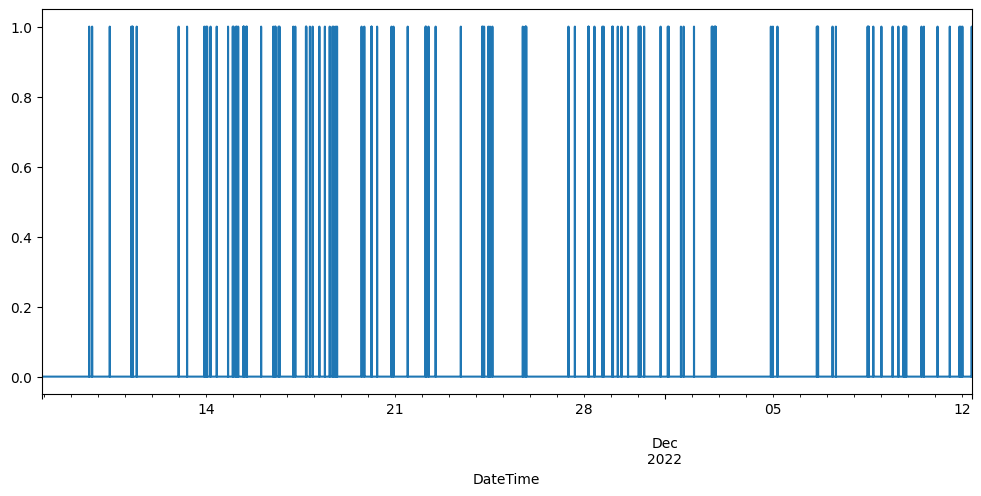

In [ ]:
anomaly_df.outlier.plot(figsize = (12, 5))

In [ ]:
new_data = anomaly_df.merge(data['downtime'], left_index= True, right_index= True, how="left")

In [ ]:
new_data

,GLA3_RE_258_740,MAE,moving_average,std,outlier,downtime
DateTime,,,,,,
2022-11-07 22:13:00,-2.262746,0.022947,0.023248,0.000271,0,1
2022-11-07 22:14:00,-2.262829,0.023522,0.023268,0.000280,0,1
2022-11-07 22:15:00,-2.262478,0.022928,0.023257,0.000290,0,1
2022-11-07 22:16:00,-2.262728,0.023686,0.023281,0.000310,0,1
2022-11-07 22:17:00,-2.262866,0.023360,0.023297,0.000308,0,1
...,...,...,...,...,...,...
2022-12-12 08:29:00,0.799855,0.048335,0.034517,0.023817,0,0
2022-12-12 08:30:00,0.812473,0.017121,0.030011,0.019675,0,0
2022-12-12 08:31:00,0.820609,0.031545,0.028867,0.018997,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


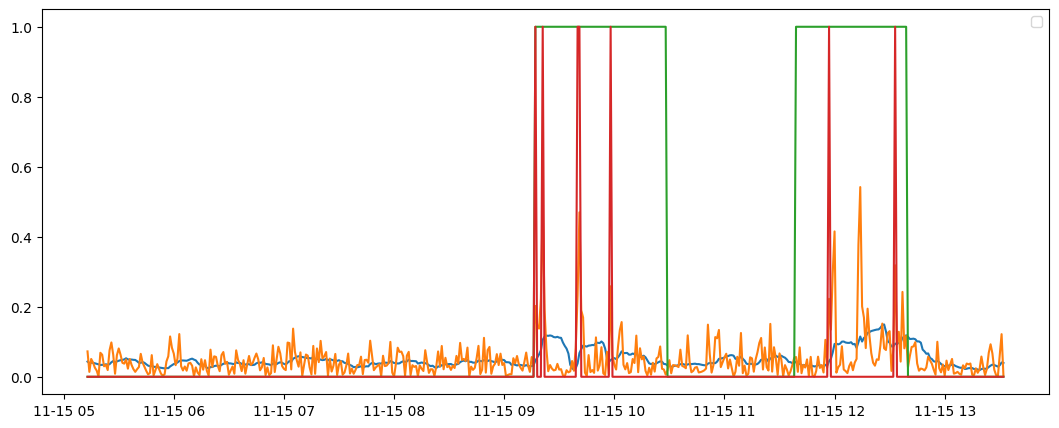

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(new_data['moving_average'][10500:11000])
plt.plot(new_data['MAE'][10500:11000])
plt.plot(new_data['downtime'][10500:11000])
plt.plot(new_data['outlier'][10500:11000])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


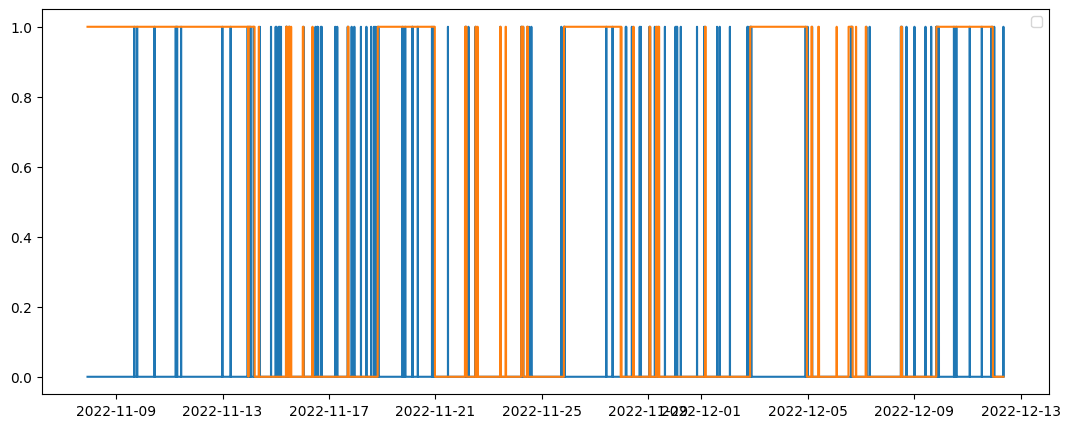

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(new_data['outlier'])
plt.plot(new_data['downtime'])
plt.legend()
plt.show()

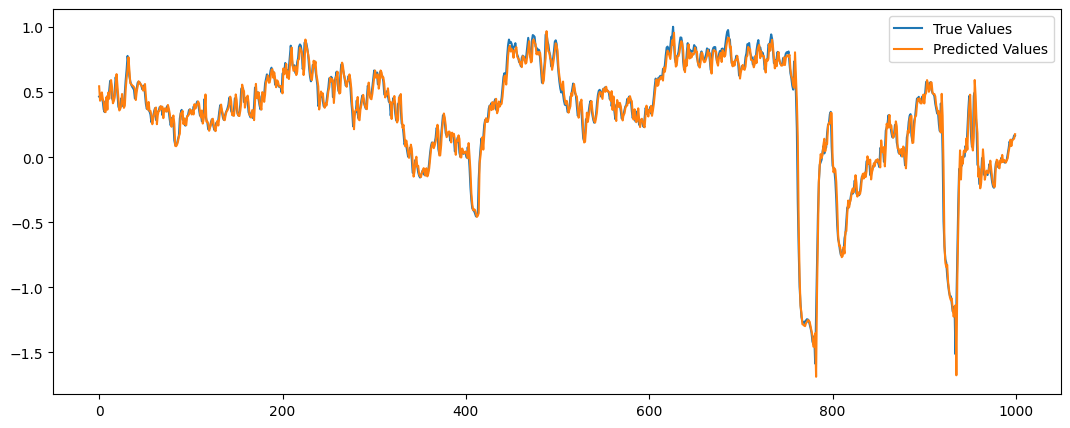

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df_reshape['GLA3_RE_258_740'][10000:11000]), label='True Values')
plt.plot(y_pred[10000:11000], label='Predicted Values')
plt.legend()
plt.show()

In [ ]:
feature_scaler = StandardScaler()
feature_scaler.fit(df[['GLA3_RE_258_740']])

StandardScaler()

In [ ]:
feature_scaler.mean_

array([5.68994369])

In [ ]:
scaler.mean_

array([  9.74725325,  12.56628737, -13.1564736 , -12.2735584 ,
        -1.6103592 ,   5.68994369,  32.94099846, 601.37228832])

In [ ]:
def LSTM_evaluation(test_ds, test_df):

    y_pred = model.predict(test_ds)
    y_true_inverse = pd.DataFrame(feature_scaler.inverse_transform(test_df_reshape), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    y_pred_inverse =  pd.DataFrame(feature_scaler.inverse_transform(y_pred), columns=test_df.columns, index=test_df[-len(y_pred):].index)
    result = pd.DataFrame(columns=test_df.columns, index=['MSE', 'MAE', 'MAPE'])

    print(y_true_inverse)
    print(y_pred_inverse)

    for i in range(len(test_df.columns)):
        result.loc['MSE', test_df.columns[i]] = mean_squared_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])
        result.loc['MAE', test_df.columns[i]] = mean_absolute_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])
        result.loc['MAPE', test_df.columns[i]] = mean_absolute_percentage_error(y_true_inverse.iloc[:, i], y_pred_inverse.iloc[:, i])

    return result


In [ ]:
result = LSTM_evaluation(test_ds, test_df)
result

   1/1550 [..............................] - ETA: 2:03

1550/1550 [==============================] - 14s 9ms/step
                     GLA3_RE_258_740
DateTime                            
2022-11-07 21:59:00         0.003255
2022-11-07 22:00:00         0.003730
2022-11-07 22:01:00         0.003798
2022-11-07 22:02:00         0.004250
2022-11-07 22:03:00         0.004024
...                              ...
2022-12-12 08:29:00         7.699632
2022-12-12 08:30:00         7.731337
2022-12-12 08:31:00         7.751778
2022-12-12 08:32:00         8.031976
2022-12-12 08:33:00         7.992079

[49595 rows x 1 columns]
                     GLA3_RE_258_740
DateTime                            
2022-11-07 21:59:00         0.149515
2022-11-07 22:00:00         0.149738
2022-11-07 22:01:00         0.150270
2022-11-07 22:02:00         0.150175
2022-11-07 22:03:00         0.150788
...                              ...
2022-12-12 08:29:00         7.567325
2022-12-12 08:30:00         7.676343
2022-12-12 08:31:00         7.663167
2022-12-12 08:32:00         

,GLA3_RE_258_740
MSE,0.020239
MAE,0.121626
MAPE,13312897119227.851562


## LSTMAE II

In [ ]:
merged_downtime

,GLA3_RE_258_740_pred,downtime
DateTime,,
2022-08-25 23:15:00,7.288429,0
2022-08-25 23:16:00,7.293935,0
2022-08-25 23:17:00,7.272147,0
2022-08-25 23:18:00,7.334298,0
2022-08-25 23:19:00,7.325228,0
...,...,...
2022-10-06 14:51:00,7.443511,0
2022-10-06 14:52:00,7.433702,0
2022-10-06 14:53:00,7.440994,0


In [ ]:
n = len(merged_downtime)
train = merged_downtime[:int(n*.8)]
test = merged_downtime[int(n*.8):]

In [ ]:
scaler = StandardScaler()
train['GLA3_RE_258_740_pred'] = scaler.fit_transform(train[['GLA3_RE_258_740_pred']])
test['GLA3_RE_258_740_pred'] = scaler.fit_transform(test[['GLA3_RE_258_740_pred']])


<ipython-input-104-f231e2af0733>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['GLA3_RE_258_740_pred'] = scaler.fit_transform(train[['GLA3_RE_258_740_pred']])
<ipython-input-104-f231e2af0733>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GLA3_RE_258_740_pred'] = scaler.fit_transform(test[['GLA3_RE_258_740_pred']])


In [ ]:
window_width = 15

In [ ]:
def to_sequence(x, y, window_width):
  x_values = []
  y_values = []

  for i in range (len(x)-window_width):
    x_values.append(x.iloc[i:(i+window_width)].values)
    y_values.append(y.iloc[i+window_width])

  return np.array(x_values), np.array(y_values)

In [ ]:
trainX, trainY = to_sequence(train[['GLA3_RE_258_740_pred']], train['GLA3_RE_258_740_pred'], window_width)
testX, testY = to_sequence(test[['GLA3_RE_258_740_pred']], test['GLA3_RE_258_740_pred'], window_width)

In [ ]:
trainX.shape

(47969, 15, 1)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(64, return_sequences = False))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(128, return_sequences = True))
model.add(TimeDistributed(Dense( trainX.shape[2])))

In [ ]:
model.compile(loss='mse',
              optimizer=tf.optimizers.Adam(),
              metrics='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 15, 128)           66560     
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 15, 64)           0         
 )                                                               
                                                                 
 lstm_13 (LSTM)              (None, 15, 64)            33024     
                                                                 
 lstm_14 (LSTM)              (None, 15, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 15, 1)            129       
 ibuted)                                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [ ]:
history = model.fit(trainX, trainY, epochs=10, validation_split=0.1, batch_size=32, callbacks=[early_stop])

Epoch 1/10
1350/1350 [==============================] - 117s 87ms/step - loss: 1.0699 - mse: 1.0699 - val_loss: 0.3717 - val_mse: 0.3717
Epoch 2/10
1350/1350 [==============================] - 113s 84ms/step - loss: 1.0699 - mse: 1.0699 - val_loss: 0.3650 - val_mse: 0.3650
Epoch 3/10
1350/1350 [==============================] - 111s 82ms/step - loss: 1.0698 - mse: 1.0698 - val_loss: 0.3594 - val_mse: 0.3594
Epoch 4/10
1350/1350 [==============================] - 115s 85ms/step - loss: 1.0699 - mse: 1.0699 - val_loss: 0.3708 - val_mse: 0.3708
Epoch 5/10
1350/1350 [==============================] - 113s 84ms/step - loss: 1.0695 - mse: 1.0695 - val_loss: 0.3629 - val_mse: 0.3629
Epoch 5: early stopping


In [ ]:
y_pred = model.predict(testX)

375/375 [==============================] - 11s 29ms/step


In [ ]:
y_pred.shape

(11982, 15, 1)

In [ ]:
testY.shape

(11982,)

In [ ]:
testMAE = np.mean(np.abs(y_pred - testX), axis=1)

(array([2.790e+02, 4.350e+02, 5.140e+02, 6.110e+02, 6.920e+02, 7.420e+02,
        9.220e+02, 9.230e+02, 8.510e+02, 8.530e+02, 1.046e+03, 1.168e+03,
        5.910e+02, 6.700e+01, 2.400e+01, 1.800e+01, 1.200e+01, 8.000e+00,
        3.100e+01, 2.300e+01, 2.900e+01, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.126e+03]),
 array([0.02446168, 0.08918161, 0.15390153, 0.21862146, 0.28334138,
        0.34806132, 0.41278124, 0.47750115, 0.54222107, 0.60694098,
        0.67166096, 0.73638088, 0.80110079, 0.86582071, 0.93054062,
        0.99526054, 1.05998051, 1.12470043, 1.18942034, 1.25414026,
        1.31886017, 1.38358009, 1.4483    , 1.51301992, 1.57773983,
        1.64245987, 1.70717978, 1.7718997 , 1.83661962, 1.90133953,
        1.96605945]),
 <BarContainer object of 30 artists>)

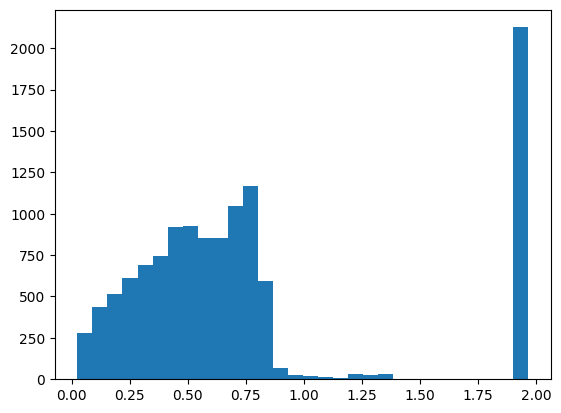

In [ ]:
plt.hist(testMAE, bins=30)

In [ ]:
test[window_width:]

,GLA3_RE_258_740_pred,downtime
DateTime,,
2022-09-28 07:14:00,-0.430945,0
2022-09-28 07:15:00,-0.353063,0
2022-09-28 07:16:00,-0.393625,0
2022-09-28 07:17:00,-0.463212,0
2022-09-28 07:18:00,-0.466989,0
...,...,...
2022-10-06 14:51:00,0.797887,0
2022-10-06 14:52:00,0.793989,0
2022-10-06 14:53:00,0.796887,0


In [ ]:
anomaly_df = pd.DataFrame(test[window_width:])
anomaly_df['TestMAE'] = testMAE
anomaly_df['max_testMAE'] = 1
anomaly_df['real'] = test[window_width:]['GLA3_RE_258_740_pred']

In [ ]:
testY.shape

(11982,)

In [ ]:
testX.shape

(11982, 15, 1)

In [ ]:
y_pred.shape

(11982, 15, 1)

In [ ]:
len(y_pred_reshaped)

179730

## LSTM Classifier

In [ ]:
data = data[int(len(data)*0.9):]
data


,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_EM_158_140,GLA3_EM_158_144,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
DateTime,,,,,,,,,,,,
2022-11-07 21:44:00,-0.599254,-1.146579,0.441780,0.689399,-0.093992,-1.999622,-0.010998,-2.263126,-0.70184,-1.166367,0,1
2022-11-07 21:45:00,-0.599254,-1.146579,0.438936,0.687431,-0.090947,-2.008296,-0.010998,-2.263074,-0.70184,-1.169928,0,1
2022-11-07 21:46:00,-0.599254,-1.146579,0.443152,0.685548,-0.092263,-2.004724,-0.010998,-2.262866,-0.70184,-1.171235,0,1
2022-11-07 21:47:00,-0.599254,-1.146579,0.442962,0.691271,-0.093747,-1.996374,-0.010998,-2.263082,-0.70184,-1.175769,0,1
2022-11-07 21:48:00,-0.599254,-1.146579,0.444290,0.691012,-0.090238,-2.005237,-0.010998,-2.263298,-0.70184,-1.177510,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12 08:29:00,-0.599254,-1.146579,0.157296,0.893576,-0.222329,0.669659,-0.010998,0.799855,-0.70184,-1.587910,0,0
2022-12-12 08:30:00,-0.599254,-1.146579,0.268279,0.835884,-0.207674,0.687291,-0.010998,0.812473,-0.70184,-1.661883,0,0
2022-12-12 08:31:00,-0.599254,-1.146579,0.168004,0.780759,-0.344151,0.723098,-0.010998,0.820609,-0.70184,-1.700657,0,0


In [ ]:
data.columns

Index(['GLA01_BL_258_104', 'GLA01_CH_258_020', 'GLA3_CO_258_024',
       'GLA3_CO_258_028', 'GLA3_CO_258_032', 'GLA3_EM_158_140',
       'GLA3_EM_158_144', 'GLA3_RE_258_740', 'GLA3_RP_258_004',
       'GLA3_SC_258_016', 'trigger', 'downtime'],
      dtype='object')

In [ ]:
data= data[['GLA3_CO_258_024', 'downtime']]
data

,GLA3_CO_258_024,downtime
DateTime,,
2022-11-07 21:44:00,0.441780,1
2022-11-07 21:45:00,0.438936,1
2022-11-07 21:46:00,0.443152,1
2022-11-07 21:47:00,0.442962,1
2022-11-07 21:48:00,0.444290,1
...,...,...
2022-12-12 08:29:00,0.157296,0
2022-12-12 08:30:00,0.268279,0
2022-12-12 08:31:00,0.168004,0


In [ ]:
X = y_pred
y = test_df2['downtime'][:158023]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
def trainingModel(model):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [ ]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.8365220326112177


In [ ]:
y_test.values

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [ ]:
results = pd.DataFrame(X, y).reset_index().rename(columns={0:'y_pred'})
results

,downtime,y_pred
0,0,0.506162
1,0,0.429073
2,0,0.409014
3,0,0.465091
4,0,0.513906
...,...,...
158018,1,0.535131
158019,1,0.535740
158020,1,0.535463
158021,1,0.534976


In [ ]:
results.to_csv("predictive_maintenance.csv")

In [ ]:
X = results['y_pred'].values.reshape(-1, 1)

In [ ]:
X

array([[0.50616163],
       [0.42907268],
       [0.40901375],
       ...,
       [0.5354626 ],
       [0.5349761 ],
       [0.5356531 ]], dtype=float32)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Assuming you have the following dataframe:
# df: Dataframe containing 'downtime' and 'y_pred' columns

# Extract features and labels from the dataframe
# X = results['y_pred'].values.reshape(-1, 1)  # Reshape to a 2D array [num_samples, num_features]
# y = results['downtime'].values.reshape(-1, 1)  # Reshape to a 2D array [num_samples, 1]

X = data['GLA3_CO_258_024'].values.reshape(-1, 1)  # Reshape to a 2D array [num_samples, num_features]
y = data['downtime'].values.reshape(-1, 1)  # Reshape to a 2D array [num_samples, 1]

# Split the data into training and testing sets (you can adjust the split ratio as needed)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Define the LSTM model
model = keras.Sequential()
model.add(layers.LSTM(64, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Once the model is trained, you can use it for predictions
y_pred = model.predict(X_test)

# Threshold the predictions to obtain binary class labels
y_pred_binary = np.round(y_pred)

# Get the first moment of downtime prediction
first_downtime = np.argmax(y_pred_binary, axis=1)

# Evaluate the model's performance by comparing the predicted first downtime moments with the actual first downtime moments
accuracy = np.mean(first_downtime == y_test.squeeze())



Epoch 1/10
1241/1241 [==============================] - 12s 6ms/step - loss: 0.3834 - accuracy: 0.9212
Epoch 2/10
1241/1241 [==============================] - 8s 6ms/step - loss: 0.2687 - accuracy: 0.9401
Epoch 3/10
1241/1241 [==============================] - 9s 7ms/step - loss: 0.2553 - accuracy: 0.9411
Epoch 4/10
1241/1241 [==============================] - 8s 6ms/step - loss: 0.2443 - accuracy: 0.9417
Epoch 5/10
1241/1241 [==============================] - 8s 6ms/step - loss: 0.2339 - accuracy: 0.9430
Epoch 6/10
1241/1241 [==============================] - 8s 6ms/step - loss: 0.2243 - accuracy: 0.9445
Epoch 7/10
1241/1241 [==============================] - 7s 6ms/step - loss: 0.2184 - accuracy: 0.9453
Epoch 8/10
1241/1241 [==============================] - 6s 4ms/step - loss: 0.2159 - accuracy: 0.9460
Epoch 9/10
1241/1241 [==============================] - 7s 5ms/step - loss: 0.2150 - accuracy: 0.9459
Epoch 10/10
311/311 [==============================] - 2s 5ms/step


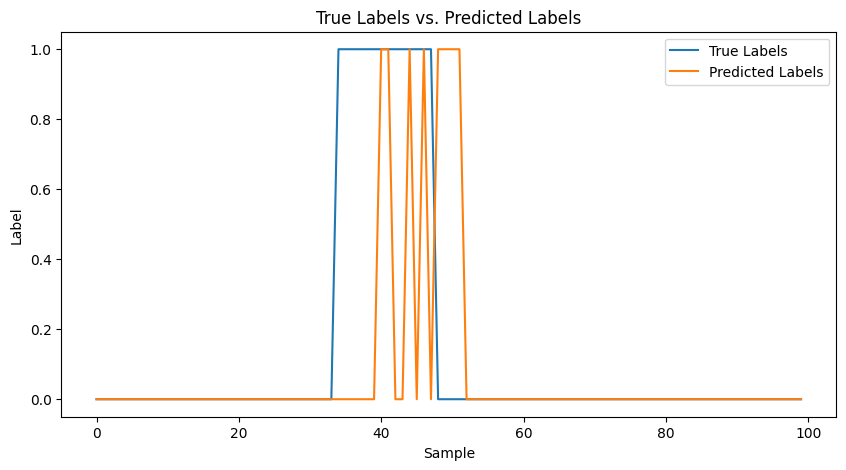

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# y_test: True labels of shape [num_samples, 1]
# y_pred_binary: Predicted binary class labels of shape [num_samples, 1]

# Flatten the labels arrays
y_test = y_test.squeeze()
y_pred_binary = y_pred_binary.squeeze()

# Plot the true labels and predicted labels
plt.figure(figsize=(10, 5))
plt.plot(y_test[1900:2000], label='True Labels')
plt.plot(y_pred_binary[1900:2000], label='Predicted Labels')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.title('True Labels vs. Predicted Labels')
plt.legend()
plt.show()


In [ ]:
# Assuming you have the following variables:
# y_test: True labels of shape [num_samples,]
# y_pred_binary: Predicted binary class labels of shape [num_samples,]

# Find the index of the first occurrence of downtime in the predicted labels
predicted_downtime_index = np.argmax(y_pred_binary)

# Find the index of the first occurrence of downtime in the true labels
true_downtime_index = np.argmax(y_test)

# Calculate the lag
lag = true_downtime_index - predicted_downtime_index

print("Lag:", lag)


Lag: 368


ValueError: x and y can be no greater than 2D, but have shapes (31605,) and (31605, 1, 1)

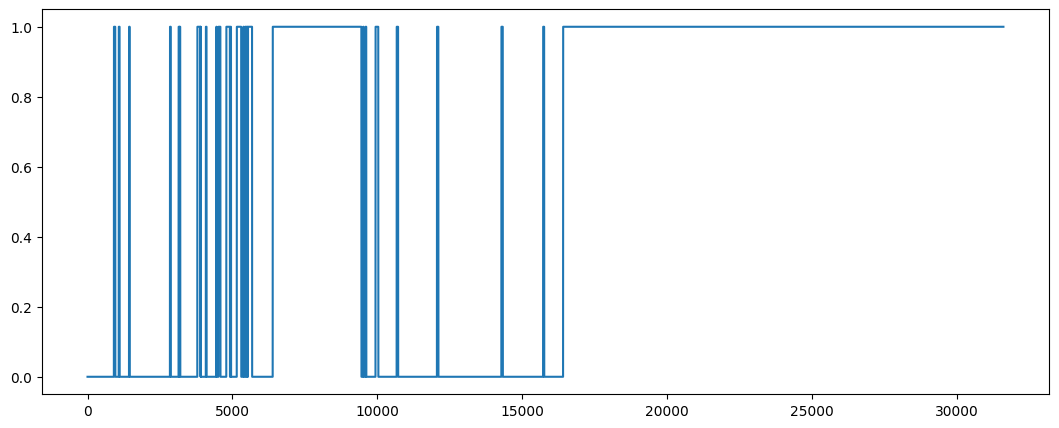

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot((y_test), label='True Values')
plt.plot(y_pred_binary, label='Predicted Values')
plt.legend()
plt.show()

# Downtime Trigger classification

## Data processing

In [ ]:
df = pd.read_csv('./dataframes/data_preprocessed_seconds.csv')
df.head()

,DateTime,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
0,2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
1,2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
2,2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
3,2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,NaN,NaN,NaN
4,2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,NaN,NaN,NaN


In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.fillna(0, inplace=True)
df.set_index('DateTime', inplace=True)
df.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231
DateTime,,,,,,
2022-01-01 00:00:00,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:01,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:02,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:03,-73.820892,0.126587,-2.549911,0.0,0.0,0.0
2022-01-01 00:00:04,-73.820892,0.126587,-2.549911,0.0,0.0,0.0


In [ ]:
df['trigger'] = (df['downtime'].diff() == 1).astype(int)
df.trigger.value_counts()

0    31535375
1         626
Name: trigger, dtype: int64

In [ ]:
tags = df.iloc[:,0:3].columns.tolist()
alarms = df.iloc[:,3:].columns.tolist()
agg_dict = {col: 'max' if col in alarms else 'mean' for col in df.columns}

In [ ]:
df_minute = df.groupby(pd.Grouper(freq='1T')).agg(agg_dict)

In [ ]:
from mpld3 import plugins
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(data['GLA3_CO_258_024'][:44000], label='024')
ax.plot(data['GLA3_CO_258_028'][:44000], label='028')
ax.plot(data['GLA3_CO_258_032'][:44000], label='032')
ax.plot(data['downtime'][:44000], label='DOWNTIME')

ax.legend()

# Enable zooming using mpld3
plugins.connect(fig, plugins.Zoom())

# Show the plot
mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


In [ ]:
df_minute.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [ ]:
dataframe = df_minute[~((df_minute['downtime'] == 1) & (df_minute['trigger'] == 0))]

In [ ]:
dataframe.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

In [ ]:
dataframe.isna().sum()

GLA3_CO_258_024    0
GLA3_CO_258_028    0
GLA3_CO_258_032    0
downtime           0
alarm_11225        0
alarm_11231        0
trigger            0
dtype: int64

In [ ]:
df = dataframe.copy()

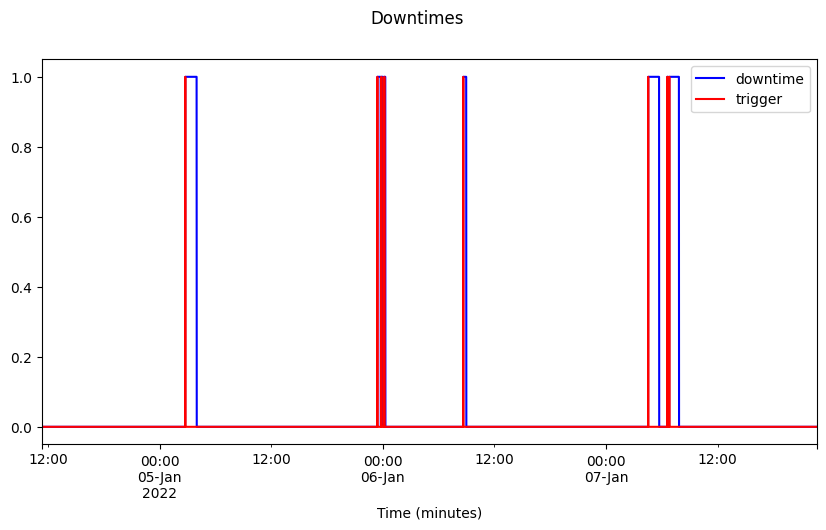

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
df_minute['downtime'][5000:10000].plot(ax =ax, color='blue', label='downtime')
df_minute['trigger'][5000:10000].plot(ax=ax, color='red', label='trigger')


# add a legend and axis labels to the whole figure
fig.suptitle('Downtimes')
plt.xlabel('Time (minutes)')
plt.legend()

# show the plot
plt.show()

In [ ]:
numerical_features = ['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']
categorical_cols = ['alarm_11225', 'downtime', 'alarm_11231', 'trigger']

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
data = dataframe.copy()

In [ ]:
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

## ML Model classifier

In [ ]:
X = data[['GLA3_CO_258_024', 'GLA3_CO_258_028', 'GLA3_CO_258_032']].values
y = data['trigger'].values

In [ ]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231,trigger
DateTime,,,,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0,0,0,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0,0,0,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0,0,0,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0,0,0,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0,0,0,0
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0,0,0,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0,0,0,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_overesampled, y_overresampled = oversample.fit_resample(X, y)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
print(f'X shape is {X_train.shape[0]} and after resampling {X_resampled.shape[0]}')


X shape is 293050 and after resampling 848


In [ ]:
def trainingModel(model):
    model = model
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

In [ ]:
trainingModel(DecisionTreeClassifier())

Accuracy: 0.6230283534910385


In [ ]:
model = DecisionTreeClassifier()
model.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['downtime','no-downtime']))

              precision    recall  f1-score   support

    downtime       1.00      0.62      0.77    125391
 no-downtime       0.00      0.67      0.01       202

    accuracy                           0.62    125593
   macro avg       0.50      0.65      0.39    125593
weighted avg       1.00      0.62      0.76    125593



In [ ]:
data.trigger.value_counts()

0    418017
1       626
Name: trigger, dtype: int64

## LSTM forecaster

In [ ]:
df = data.copy()

In [ ]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime,alarm_11225,alarm_11231,downtime
DateTime,,,,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0,0,0,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0,0,0,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0,0,0,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0,0,0,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0,0,0,0
...,...,...,...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0,0,0,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0,0,0,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0,0,0,0


In [ ]:
df.drop(columns=['downtime', 'alarm_11225', 'alarm_11231'], inplace=True)

KeyError: "['downtime', 'alarm_11225', 'alarm_11231'] not found in axis"

In [ ]:
data = df

In [ ]:
data.head()

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,trigger
DateTime,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0


In [ ]:
data.rename(columns={'trigger':'downtime'}, inplace=True)

In [ ]:
data.dtypes

GLA3_CO_258_024    float64
GLA3_CO_258_028    float64
GLA3_CO_258_032    float64
downtime             int64
dtype: object

In [ ]:
n = len(data)
train_df = data[0:int(n*0.8)]
val_df = data[int(n*0.8):int(n*0.9)]
test_df = data[int(n*0.9):]

<Axes: xlabel='DateTime'>

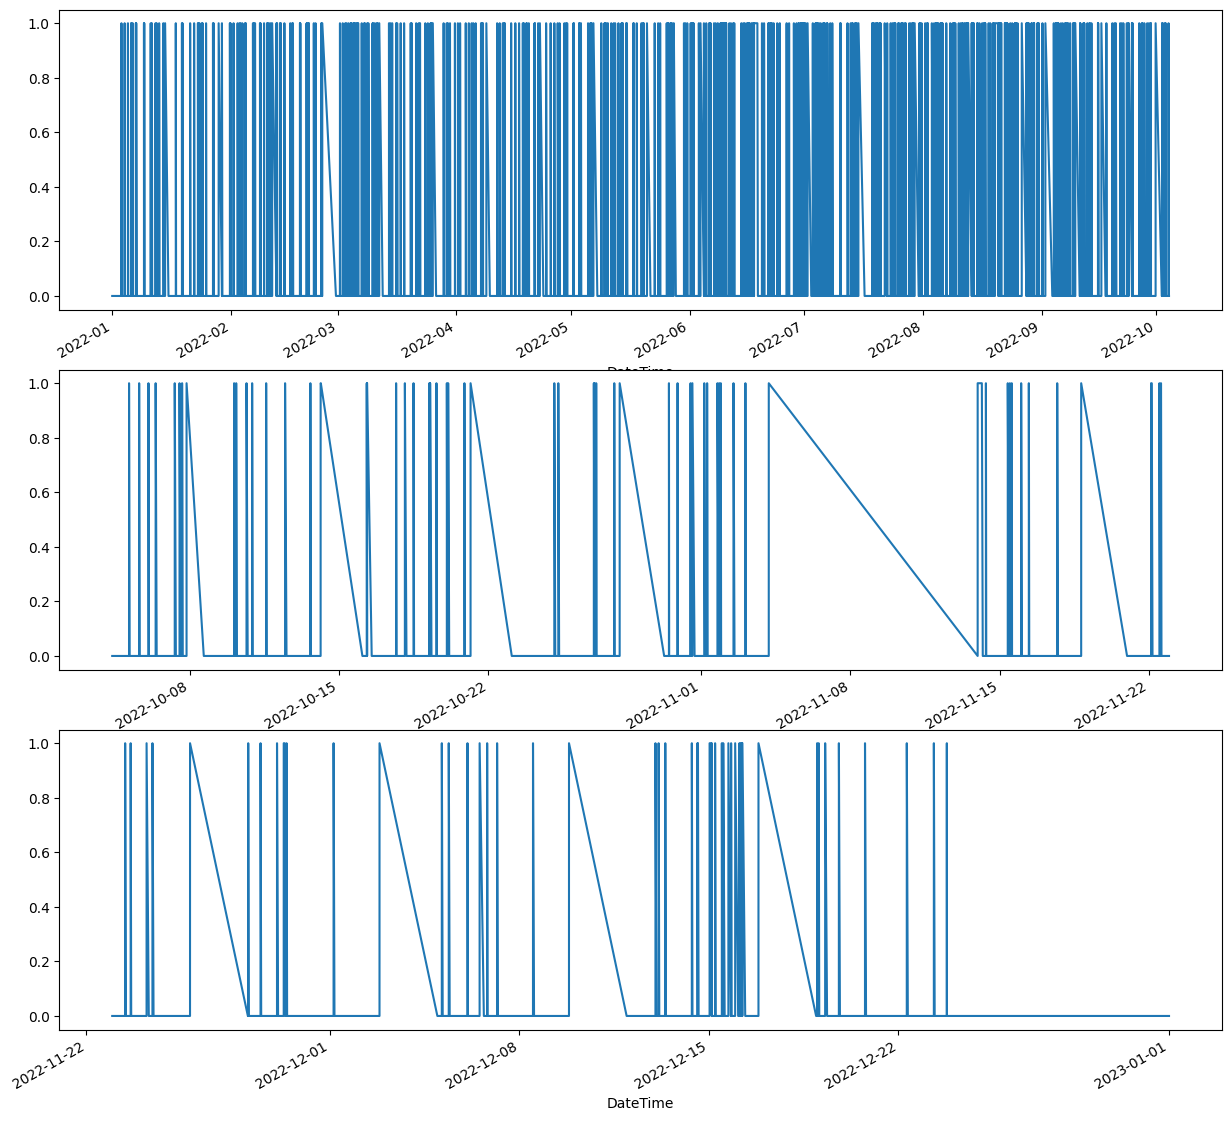

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
train_df['downtime'].plot(ax =ax1)
val_df['downtime'].plot(ax=ax2)
test_df['downtime'].plot(ax=ax3)

In [ ]:
data

,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,downtime
DateTime,,,,
2022-01-01 00:00:00,-2.773075,0.767275,-0.079110,0
2022-01-01 00:01:00,-2.768918,0.761455,-0.080125,0
2022-01-01 00:02:00,-2.781714,0.765187,-0.077818,0
2022-01-01 00:03:00,-2.772603,0.762089,-0.078570,0
2022-01-01 00:04:00,-2.776450,0.760770,-0.077225,0
...,...,...,...,...
2022-12-31 23:56:00,0.448540,0.721742,-0.158425,0
2022-12-31 23:57:00,0.449917,0.716949,-0.154997,0
2022-12-31 23:58:00,0.451658,0.730301,-0.161457,0


In [ ]:

class WindowGenerator2:
    def __init__(self, input_width, label_width, shift, train_df, val_df,
                 test_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)} #creates a dictionary with the name of the label column and the position

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)} #creates a dictionary with the name of the train column and the position

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        #slice(start, end, step)
        self.input_slice = slice(0, input_width) #start in index 0 and take every inp width record
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_windows(self, features):

        print(f'features are {features}')

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]


        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])


        return inputs, labels


    def make_dataset(self, data):
        data = np.array(data)
        ds = timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=1,)
        ds = ds.map(self.split_windows)
        print(f'ds is {ds}')

        return ds


In [ ]:
window_generator = WindowGenerator(input_width=5, label_width=1,
                                   shift=5, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['downtime'])

In [ ]:
train_ds = window_generator.make_dataset(train_df)
val_ds = window_generator.make_dataset(train_df)
test_ds = window_generator.make_dataset(test_df)

features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
features are Tensor("args_0:0", shape=(None, None, 4), dtype=float64)
ds is <MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


In [ ]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [ ]:
class_weight = {0: 1, 1: 450}

In [ ]:
def weighted_binary_crossentropy(class_weight):
    def loss(y_true, y_pred):
        # calculate the weighted binary cross-entropy loss
        b_ce = K.binary_crossentropy(y_true, y_pred, from_logits=True)
        weight_vector = y_true * class_weight[1] + (1. - y_true) * class_weight[0]
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return loss

In [ ]:
model = Sequential([
    LSTM(32, input_shape=(window_generator.input_width, train_df.shape[-1])),
    Dense(1, activation='sigmoid')
])

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

# model.compile(loss=custom_loss(cost_matrix),
#               optimizer=tf.optimizers.Adam(),
#               metrics=[tf.metrics.BinaryAccuracy()])

model.compile(loss=weighted_binary_crossentropy(class_weight),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [ ]:
train_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 5, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>

In [ ]:
import tensorflow.keras.backend as K

In [ ]:
history = model.fit(train_ds, epochs=4, validation_data=val_ds, callbacks=[early_stop])

Epoch 1/4


c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10466/10466 [==============================] - 55s 5ms/step - loss: 1.1563 - accuracy: 0.9242 - val_loss: 1.1509 - val_accuracy: 0.8851
Epoch 2/4
10466/10466 [==============================] - 52s 5ms/step - loss: 1.1431 - accuracy: 0.9307 - val_loss: 1.1496 - val_accuracy: 0.9120
Epoch 3/4
10466/10466 [==============================] - 53s 5ms/step - loss: 1.1407 - accuracy: 0.9292 - val_loss: 1.1488 - val_accuracy: 0.9158
Epoch 4/4
10466/10466 [==============================] - 53s 5ms/step - loss: 1.1371 - accuracy: 0.9226 - val_loss: 1.1468 - val_accuracy: 0.9172


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(test_ds).round()
y_true = test_df['downtime'].values[-len(y_pred):].astype(int)
print(classification_report(y_true, y_pred))

1308/1308 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     41806
           1       0.00      0.04      0.00        50

    accuracy                           0.95     41856
   macro avg       0.50      0.50      0.49     41856
weighted avg       1.00      0.95      0.98     41856



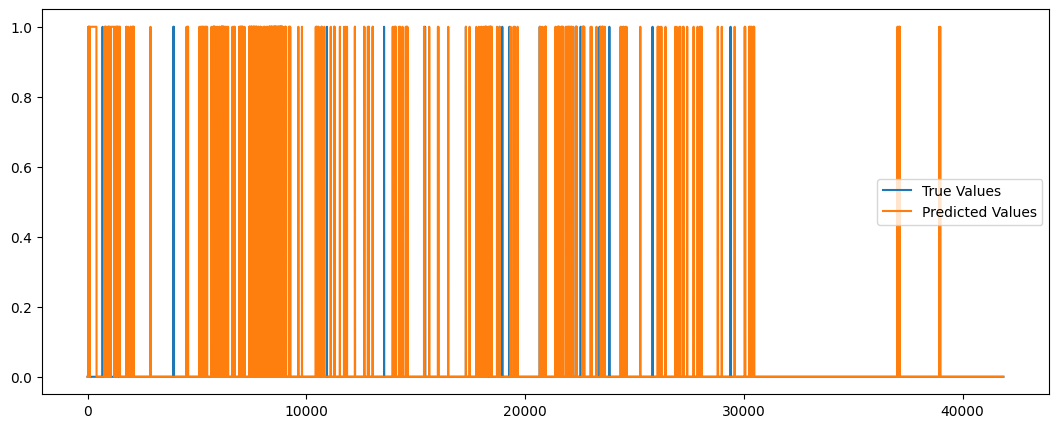

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(np.array(test_df['downtime']), label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()

In [ ]:
data = pd.read_csv('./dataframes/pivot_alarms_cleaned.csv')

In [ ]:
data.head()

,DateTime,2421,2445,4203,6280,6336,7167,9218,9219,9495,...,22019,22020,22021,22022,22024,22040,22045,24324,35002,49317
0,2022-01-03 09:53:36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2022-01-03 10:31:02,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-03 10:55:39,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2022-01-03 10:59:57,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-03 11:23:14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

In [ ]:
df_minute = data.groupby(pd.Grouper(freq='1T')).agg('max')

In [ ]:
print(f"seconds {data.shape} and after {df_minute.shape}")

seconds (81110, 30) and after (566766, 30)


# ARIMA

In [ ]:
df

,DateTime,GLA01_BL_258_104,GLA01_CH_258_020,GLA3_CO_258_024,GLA3_CO_258_028,GLA3_CO_258_032,GLA3_RE_258_740,GLA3_RP_258_004,GLA3_SC_258_016,trigger,downtime
0,2022-01-01 20:16:00,0.0,0.0,-74.095177,-0.140157,-2.388664,0.006104,0.0,90.784138,0.0,1
1,2022-01-01 20:17:00,0.0,0.0,-74.126319,-0.079374,-2.428345,0.006028,0.0,93.396345,0.0,1
2,2022-01-01 20:18:00,0.0,0.0,-74.121946,-0.076596,-2.438219,0.006000,0.0,90.465003,0.0,1
3,2022-01-01 20:19:00,0.0,0.0,-74.066162,-0.218143,-2.529572,0.005697,0.0,91.688365,0.0,1
4,2022-01-01 20:20:00,0.0,0.0,-74.076487,-0.135030,-2.472752,0.005389,0.0,92.978392,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
496093,2022-12-12 08:29:00,0.0,0.0,-8.783500,3.289984,-6.479813,7.699632,0.0,-113.348004,0.0,0
496094,2022-12-12 08:30:00,0.0,0.0,-5.698065,2.285154,-6.158857,7.731337,0.0,-146.643506,0.0,0
496095,2022-12-12 08:31:00,0.0,0.0,-8.485801,1.325036,-9.147971,7.751778,0.0,-164.095858,0.0,0
496096,2022-12-12 08:32:00,0.0,0.0,-8.080292,0.903527,-7.688693,8.031976,0.0,-160.312035,0.0,0


In [ ]:
df_arima = pd.DataFrame(df[['GLA3_CO_258_024']])
df_arima

,GLA3_CO_258_024
0,-74.095177
1,-74.126319
2,-74.121946
3,-74.066162
4,-74.076487
...,...
496093,-8.783500
496094,-5.698065
496095,-8.485801
496096,-8.080292


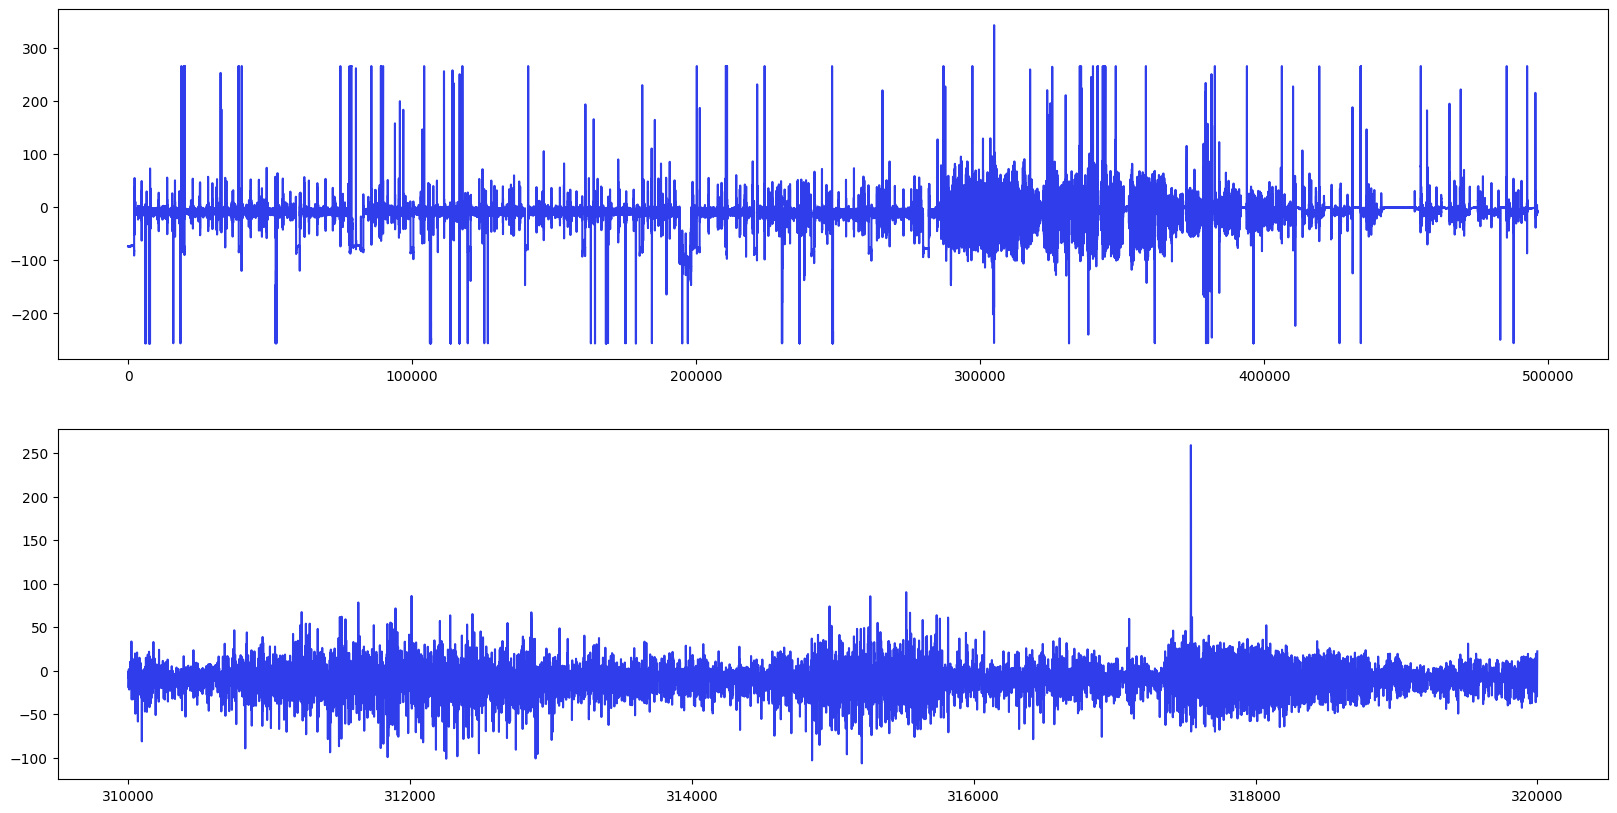

In [ ]:
f, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
ax1.plot(df_arima.index, df_arima['GLA3_CO_258_024'], color='#2F3EEA')
ax2.plot(df_arima.index[310000:320000], df_arima['GLA3_CO_258_024'][310000:320000], color='#2F3EEA')
f.show()

In [ ]:
# data = df_arima[20000:38000]
# data = df_arima[:130000]
data = df_arima[31500:34000]


In [ ]:
data = df_arima[310000:320000]

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(data)

In [ ]:
data

,GLA3_CO_258_024
310000,-4.069013
310001,-7.906942
310002,-0.599803
310003,-19.553856
310004,-7.346827
...,...
319995,11.320889
319996,-5.160110
319997,-29.571162
319998,-9.845920


In [ ]:
result[1]

0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


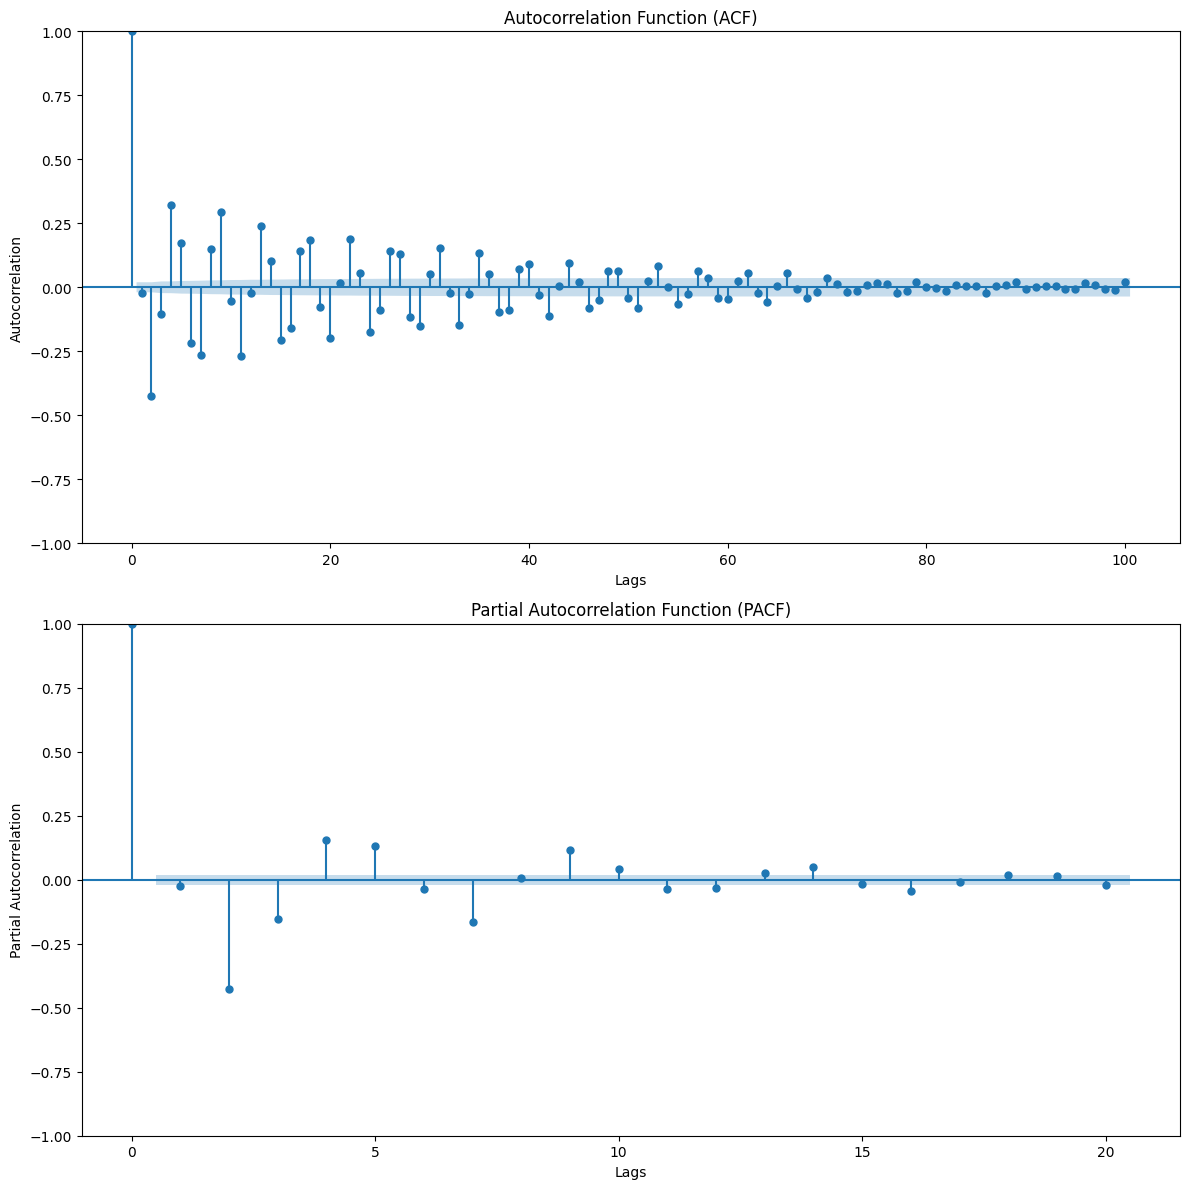

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# ACF plot
plot_acf(data, ax=ax1, lags=100)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data, ax=ax2, lags=20)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Partial Autocorrelation')
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pmdarima import auto_arima

In [ ]:
stepwise_fit = auto_arima(data['GLA3_CO_258_024'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=81828.826, Time=16.72 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=84952.209, Time=0.35 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=84949.171, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=84915.629, Time=4.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87468.948, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=83499.795, Time=7.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=82825.062, Time=9.94 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=81825.729, Time=17.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=82622.543, Time=9.62 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=81786.620, Time=23.09 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=82387.470, Time=13.16 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=81788.649, Time=29.09 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=81955.001, Time=25.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=81807.416, Time=24.21 sec
 ARIMA(5,0,1

In [ ]:
n = len(data)
X_train = data[:int(n*0.8)]
X_test = data[int(n*0.8):]


In [ ]:
import statsmodels.api as sm


In [ ]:
X_train

,GLA3_CO_258_024
310000,-4.069013
310001,-7.906942
310002,-0.599803
310003,-19.553856
310004,-7.346827
...,...
317995,-0.814626
317996,15.666672
317997,-8.234474
317998,-6.680410


In [ ]:
model = sm.tsa.ARIMA(X_train['GLA3_CO_258_024'], order=(4,0,2))  # AR(p) = AR(1), I(d) = I(1), MA(q) = MA(1)

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        GLA3_CO_258_024   No. Observations:                 8000
Model:                 ARIMA(4, 0, 2)   Log Likelihood              -33158.492
Date:                Sun, 25 Jun 2023   AIC                          66332.983
Time:                        14:32:12   BIC                          66388.881
Sample:                             0   HQIC                         66352.116
                               - 8000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0555      0.136    -66.512      0.000      -9.322      -8.789
ar.L1          0.2286      0.014     16.678      0.000       0.202       0.255
ar.L2         -1.0222      0.014    -72.384      0.0

In [ ]:
forecast = results.forecast(steps=len(X_test))

<Axes: >

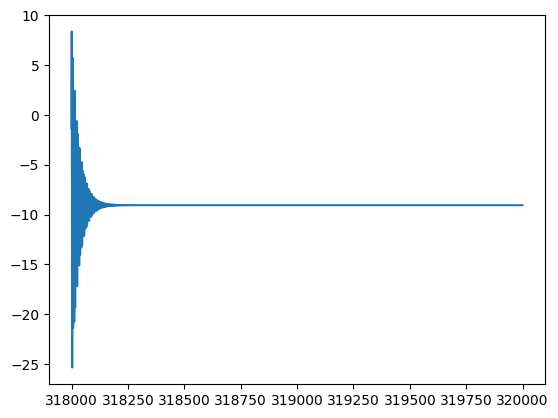

In [ ]:
forecast.plot()

In [ ]:
start= len(X_train)
end = len(X_train) + len(X_test) -1
pred = results.predict(start=start, end=end, typ='levels')

<Axes: >

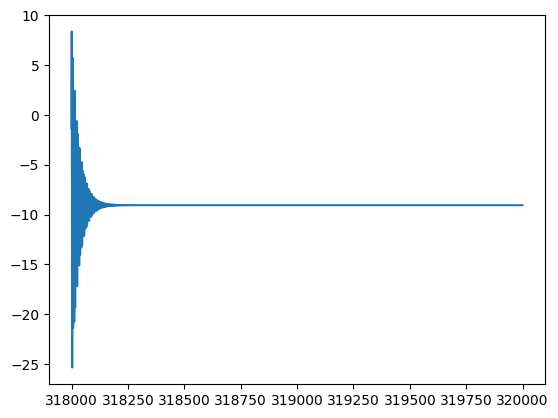

In [ ]:
pred.plot()

In [ ]:
forecast_values.plot()

NameError: ignored

In [ ]:
GLA3_RE_258_740

In [ ]:
# Predict the values
forecast_steps = 10
forecast_values = results.forecast(steps=10000)


In [ ]:
forecast_values

2022-01-25 10:56:00    5.648070
2022-01-25 10:57:00    5.673388
2022-01-25 10:58:00    5.694556
2022-01-25 10:59:00    5.704543
2022-01-25 11:00:00    5.701329
                         ...   
2022-01-26 03:31:00    6.445386
2022-01-26 03:32:00    6.445403
2022-01-26 03:33:00    6.445420
2022-01-26 03:34:00    6.445436
2022-01-26 03:35:00    6.445453
Freq: T, Name: predicted_mean, Length: 1000, dtype: float64

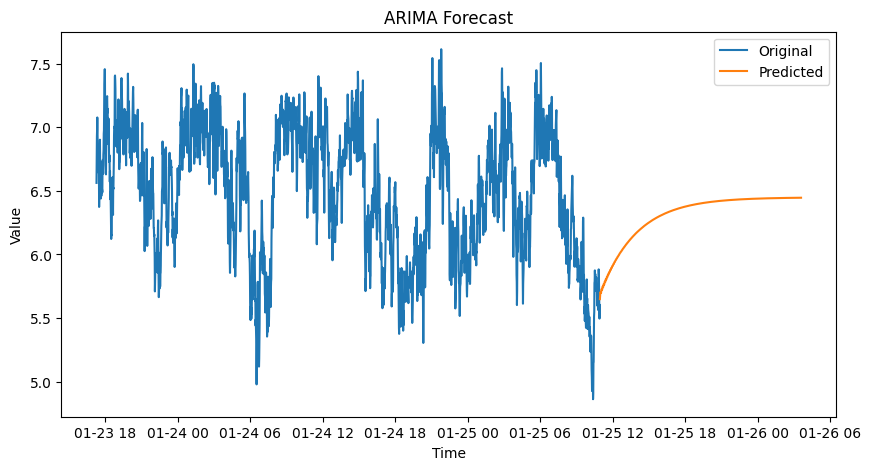

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
# Plot the original data
plt.plot(data['GLA3_RE_258_740'], label='Original')

# Plot the predicted values
plt.plot(forecast_values, label='Predicted')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
pip install pmdarima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
model = pm.auto_arima(data, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3208.609, Time=9.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2992.854, Time=0.95 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3075.386, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3094.673, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2994.833, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3204.346, Time=9.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3210.166, Time=8.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3099.089, Time=2.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3113.476, Time=2.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3208.453, Time=10.97 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3121.962, Time=1.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-3207.976, Time=15.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3212.060, Time=3.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3101.074, Time=1.24 sec
 ARIMA(2,1,0)(0,0

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               125000
Model:               SARIMAX(2, 1, 1)   Log Likelihood             -412290.137
Date:                Sun, 04 Jun 2023   AIC                         824588.274
Time:                        16:50:17   BIC                         824627.218
Sample:                    01-01-2022   HQIC                        824599.975
                         - 03-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8309      0.001    839.035      0.000       0.829       0.833
ar.L2         -0.1863      0.000   -480.692      0.000      -0.187      -0.186
ma.L1         -0.7960      0.001   -806.923      0.0

In [ ]:
result[1]

9.437322483199026e-25

In [ ]:
n = len(df_arima_short)
train_data = (df_arima_short[:int(n*0.8)])
test_data = df_arima_short[int(n*0.8):]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(4, 0, 1000))

# Fit the model to the data
model_fit = model.fit()

# Obtain the summary of the model
print(model_fit.summary())

In [ ]:
forecast_values = model_fit.forecast(steps=len(test_data))


In [ ]:
forecast_values

2022-02-15 06:56:00    0.251453
2022-02-15 06:57:00    0.241504
2022-02-15 06:58:00    0.230538
2022-02-15 06:59:00    0.221675
2022-02-15 07:00:00    0.214908
                         ...   
2022-02-26 09:31:00    0.194444
2022-02-26 09:32:00    0.194444
2022-02-26 09:33:00    0.194444
2022-02-26 09:34:00    0.194444
2022-02-26 09:35:00    0.194444
Freq: T, Name: predicted_mean, Length: 16000, dtype: float64

In [ ]:
rmse = np.sqrt(np.mean((forecast_values - test_data) ** 2))

c:\Users\manda\OneDrive - ROCKWOOL Group\Documents\Mthesis\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
mae

2022-02-15 06:56:00   NaN
2022-02-15 06:57:00   NaN
2022-02-15 06:58:00   NaN
2022-02-15 06:59:00   NaN
2022-02-15 07:00:00   NaN
                       ..
2022-02-26 09:32:00   NaN
2022-02-26 09:33:00   NaN
2022-02-26 09:34:00   NaN
2022-02-26 09:35:00   NaN
GLA3_CO_258_024       NaN
Length: 16001, dtype: float64

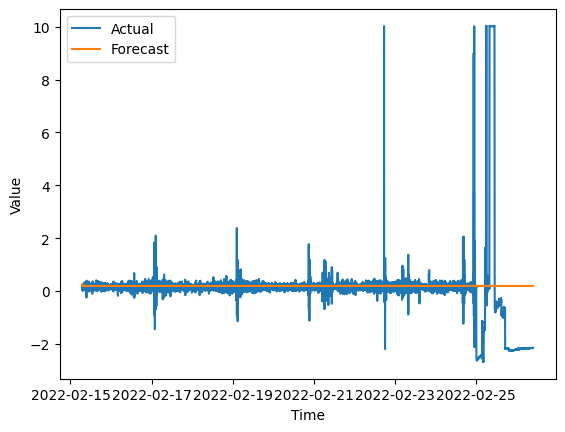

In [ ]:
# Assuming you have a fitted ARIMA model 'model_fit' and a holdout period 'test_data'

# Make predictions for the holdout period

# # Calculate MAE and RMSE
# mae = np.mean(np.abs(forecast_values - test_data))
# rmse = np.sqrt(np.mean((forecast_values - test_data) ** 2))

# # Print evaluation metrics
# print("MAE:", mae)
# print("RMSE:", rmse)


plt.plot(test_data, label='Actual')
plt.plot(forecast_values, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
